In [1]:
import mesa
import random
import numpy as np
import pandas as pd
import math

import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt


### Agent

##### Firms

In [43]:
r = 0.06 # The discount rate
dr = 0.03 # demand increase each year
gamma = 0.67
q = 1 # initial quality of each prod line
pi_rate = 0.08 # 8% profit rate
o_m = 0.015
t = 8 ### payback period
d = 0.005

class Firms(mesa.Agent):

        # Firms' strategies
        prod_line = [[], [1], [1, 1]]
        lab_prod = [[], [], [], [1]]
        
        def __init__(self, unique_id, model, c_in, c_sys, x, y):
                super().__init__(unique_id, model)

                # Financial conditions, CNY
                self.asset = random.randint(2030000, 4235000) # The fundamental cash
                self.c_f = random.randint(1, 3) # fixed cost
                self.d = d # Annual degration rate of PV (Vimpari, J. and Junnila, S., 2019)

                # PV installation
                self.pv_installed = 0
                self.elec_provide = []
                ### regular income
                self.C_i = 0


                # Strategies
                ## Production sector
                self.prod_line = random.choice(Firms.prod_line).copy()
                ### product line operational cost, per line
                self.c_op = random.randint(3, 5)
                ### product line installation cost, CNY
                self.c_in = c_in
                ### record the product line installation cost
                self.C_in = 0
                ### PV production cost CNY per W, as PV supplyer
                self.c_p = 2000
                ### PV selling price, with profit rate 8%
                self.p_t = (1 + pi_rate) * self.c_p
                ### PV system installation cost, CNY per W
                self.c_sys = c_sys
                self.t_0_prod_line = len(self.prod_line)

                ## Innovation sector
                self.lab_prod = random.choice(Firms.lab_prod).copy()
                ### initialized the knowledge capital, k
                self.k = len(self.prod_line)
                ### initialize inno step
                self.inno_step = 0
                ### initialize tech transfer income
                self.R_tr_i = 0
                ### initialize R&D cost
                self.R_rd = 0
                ### the innovation budget, % of asset
                self.inno_cost_percent = random.uniform(0, 0.3)
                ### the inno budget
                self.inno_cost = self.asset * self.inno_cost_percent
                self.t_0_inno_cost = self.inno_cost
                ### price of tech transfer
                self.R_tr = 0
                ### accumulate innovation investment
                self.R = 0
                self.max_q_prod = 1

                ## Firm type
                self.firm_type = 0
                if self.inno_cost > 0:
                        self.firm_type += 2
                if len(self.prod_line) > 0:
                        self.firm_type += 1
                self.t_0_firm_type = self.firm_type
                self.firm_type_var = 0.5

                ### record
                self.community = -1
                self.community_pe = -1
                self.pi = 0
                self.R_pi = 0
                self.source = 0
                self.P_t_i = 0
                self.C_op = 0
                self.C_p = 0
                self.P_t_c = 0
                self.C_sys = 0
                self.C_om = 0
                self.R_tr_c = 0
                self.sourceID = -1
                self.t_income = 0
                self.t_profit = 0
                self.location = self.check_loc(x, y)

                        
        def check_loc(self, x, y):
                if x < self.model.grid.width // 2 and y < self.model.grid.height // 2:
                # communities in the top-left quadrant
                        return 1
                elif x < self.model.grid.width // 2 and y >= self.model.grid.height // 2:
                # Bottom-left quadrant
                        return 2
                else:
                # right half
                        return 3

        def step(self): # The agent's step will go here.
                ### this is used for reset value to 0 for recording features
                self.re_init()

                # Income
                if self.elec_provide:
                        # sale the pv_elec to the community
                        # This step is the actual income
                        self.reg_income(self.elec_provide)
                
                

                # Deduct all expenses, including basic fixed cost, product line cost, and innovation cost.
                ### deduct the fixed cost
                self.asset -= self.c_f
                ## check the agent's asset
                if self.asset <= 0: # agent should die
                        self.die()
                else:

                        self.product_line_opcost()

                        # update inno_cost since the asset might be increased
                        #self.inno_cost = self.asset * self.inno_cost_percent
                                
                        # Production investment
                        ## surrounded and other agents
                        adj_firms, adj_communities, other_firms = self.collect_agents()
                        ### get the optimum installation amount and the targeted community
                        A_in_opt, sale_community = self.investing_pv_project(adj_communities, adj_firms)

                        if A_in_opt:
                                # install the pv
                                self.pv_installing(A_in_opt, sale_community, adj_firms, other_firms)
                        
                        # Innovation investment
                        ### check if the remained innovation budget greater than 0
                        
                        if self.inno_cost > 0:
                                self.innovating()

                        self.firm_type_check()
                        self.firm_type_var = self.firm_type_change()

                        self.step_income_profit()

        def re_init(self):
                ### reschdule the annual innovation budget
                self.community = -1
                self.community_pe = -1
                self.pi = 0
                self.R_pi = 0
                
                self.t_0_inno_cost = self.inno_cost
                self.C_i = 0
                self.C_in = 0
                self.t_0_prod_line = len(self.prod_line)
                self.t_0_firm_type = self.firm_type
                self.source = 0
                self.C_op = 0
                self.C_p = 0
                self.P_t_c = 0
                self.C_sys = 0
                self.C_om = 0
                self.R_tr_c = 0
                self.sourceID = -1
        
        def firm_type_check(self):
                if (self.t_0_prod_line > len(self.prod_line)) and len(self.prod_line) == 0:
                        self.firm_type -= 1
                if (self.t_0_inno_cost > self.inno_cost) and self.inno_cost == 0:
                        self.firm_type -= 2
        
        def firm_type_change(self):
                if self.t_0_firm_type == 3 and self.firm_type == 2:
                        return 0
                elif self.t_0_firm_type == 3 and self.firm_type == 1:
                        return -1
                elif self.t_0_firm_type == 3 and self.firm_type == 0:
                        return -4
                elif self.t_0_firm_type == 2 and self.firm_type == 1:
                        return -2
                elif self.t_0_firm_type == 2 and self.firm_type == 0:
                        return -3
                elif self.t_0_firm_type == 1 and self.firm_type == 0:
                        return -0.5
                elif self.t_0_firm_type < self.firm_type:
                        return 1
                else:
                        return 0.5
                       
        def product_line_opcost(self):
                if self.prod_line:
                        remain_asset = self.asset - self.c_op * len(self.prod_line)
                        while remain_asset < self.c_f and self.prod_line:
                                ### remove the product with the lowest quality, reducing the cost
                                low_prod = min(self.prod_line)
                                self.prod_line.remove(low_prod)
                                ### update remain_asset
                                remain_asset = self.asset - self.c_op * len(self.prod_line)
                        if remain_asset >= self.c_f:
                                self.asset -= self.c_op * len(self.prod_line)


        def reg_income(self, elec_provide):
                # The income from each community that provided by this company
                for project in elec_provide:
                        C_i = (project[1].elec_provider.get(self.unique_id, 0) * project[1].ut_hr * project[1].elec_price) * (1 - self.d) ** project[2]
                        C_om = project[1].elec_provider.get(self.unique_id, 0) * self.c_sys * o_m
                        pi = C_i - C_om
                        self.pi += pi
                        project[2] += 1
                        ### installed capacity * elec price
                        self.asset = self.asset + pi
                        ### record
                        self.C_i += C_i
                        self.C_om += C_om
                        
        def collect_agents(self):
                adjacent_agents = self.model.grid.get_neighbors(self.pos, moore=True, include_center=True)
                adj_communities = [agent for agent in adjacent_agents if isinstance(agent, Communities)]
                adj_firms = [agent for agent in adjacent_agents if isinstance(agent, Firms)] + [self]
                all_firms = [agent for agent in self.model.schedule.agents if isinstance(agent, Firms)]
                other_firms = [agent for agent in all_firms if agent != self]
                return adj_firms, adj_communities, other_firms

        def investing_pv_project(self, community_agents, firm_agents):
                ## Check if there were community nearby
                if community_agents:
                        ### get the community with the max coal demand as the invest target
                        sale_community = self.get_max_coal_demand(community_agents)
                        ### check wether to invest the community, i.e. installing PV panel
                        D_opt = self.NPV(sale_community, firm_agents)
                        return D_opt, sale_community
                else:
                        return False, False

        def get_max_coal_demand(self, communities):
                ### choose the community which has the most conventional elec demand to sale
                community_coal_demand = {}
                for community in communities:
                        community_coal_demand[community] = community.D_coal
                sale_community = max(community_coal_demand, key=community_coal_demand.get)
                return sale_community

        def NPV(self, sale_community, trade_firm):

                npv_list = []
                install_npv_dict = {}
                ## each year co
                ### the fixed cost

                for A_in in self.pv_A_in(sale_community):
                        if trade_firm:
                                max_pd_quality = []
                                for firm in trade_firm:
                                        if firm.prod_line:
                                                max_pd_quality.append(max(firm.prod_line))
                                if max_pd_quality:
                                        CAP = A_in * (self.c_p / max(max_pd_quality) + self.c_sys)
                                else:
                                       CAP = A_in * (self.c_p + self.c_sys) 
                        else:
                                CAP = A_in * (self.c_p + self.c_sys)

                        
                        if CAP < self.asset:
                                npv = self.EV(CAP, A_in, sale_community)
                                npv_list.append(npv)
                                install_npv_dict[A_in] = npv

                if npv_list:
                        opt_npv = max(npv_list)
                        A_in_opt = max(install_npv_dict, key=install_npv_dict.get)
                
                        if opt_npv > 0:
                                return A_in_opt 
                        else:
                                return False
                else:
                        return False

        def pv_A_in(self, sale_community):
                # The installation cost depends on the number of community residence and their elec demand
                ### conver the demand(kWh) to installation capacity (kW)
                pv_install_list = [D_coal / sale_community.ut_hr for D_coal in np.linspace(0, sale_community.D_coal, 100)]

                return pv_install_list

        def pv_installing(self, A_in, sale_community, adj_firms, other_firms):
                
                CAP, source = self.install_cost(A_in, adj_firms, other_firms)
                
                ### directly installation
                if source == 1:
                        CAP_d = CAP
                        npv = self.EV(CAP_d, A_in, sale_community)
                        if npv > 0:
                                self.source = source
                                self.asset -= CAP_d
                                self.pv_installation(A_in, sale_community)

                ### trading PV
                elif source == 2:
                        CAP_buy = CAP
                        npv = self.EV(CAP_buy, A_in, sale_community)
                        if npv > 0:
                                self.source = source
                                self.pv_trade(adj_firms, A_in, CAP_buy)
                                self.pv_installation(A_in, sale_community)

                ### innovation commercialization
                elif source == 3:
                        CAP_rd = CAP
                        npv = self.EV(CAP_rd, A_in, sale_community)
                        if npv > 0:
                                self.source = source
                                self.asset -= CAP_rd
                                self.prod_line.append(max(self.lab_prod))
                                ### update production cost
                                self.c_p = self.c_p / max(self.prod_line)
                                ### update price
                                self.p_t = self.p_t / max(self.prod_line)
                                self.pv_installation(A_in, sale_community)
                                ### record
                                self.C_in += self.c_in

                ### tech adoption and production
                elif source == 4:
                        CAP_tr = CAP
                        tech_tr_firm = self.potential_tech_tr(other_firms)
                        ### select the tech with minimum transfer cost
                        R_tr = tech_tr_firm.R_tr
                        c_in = self.c_in
                        npv = self.EV(CAP_tr, A_in, sale_community)
                        ### the adoption cost is included in the innovation budget
                        if self.inno_cost >= R_tr and npv > 0:
                                self.source = source
                                ### trade the tech
                                self.asset = self.asset - CAP_tr
                                ### the firm that provide the tech will benefit from the tech transfer
                                tech_tr_firm.asset = tech_tr_firm.asset + R_tr 
                                self.prod_line.append(min(tech_tr_firm.prod_line))
                                self.lab_prod.append(min(tech_tr_firm.prod_line))
                                ### update the R&D budget
                                self.R_rd = self.inno_cost - R_tr
                                ### update c_p
                                self.c_p = self.c_p / max(self.prod_line)
                                ### update price
                                self.p_t = self.p_t / min(self.prod_line)
                                self.pv_installation(A_in, sale_community)
                                ### recording
                                tech_tr_firm.R_tr_i += R_tr
                                self.R_tr_c += R_tr
                                self.C_in = c_in
                                self.sourceID = tech_tr_firm.unique_id
                        
                
                else:
                        pass

        def pv_trade(self, adj_firms, A_in, CAP_buy):
                pv_trade_firm = self.potential_trader(adj_firms)    
                # trading price
                p_t = pv_trade_firm.p_t
                # production cost
                PVcost = pv_trade_firm.c_p
                ### trading profit
                pi = p_t - PVcost
                # update the asset
                self.asset -= CAP_buy
                pv_trade_firm.asset += pi * A_in 
                ### record
                self.P_t_c += p_t * A_in
                pv_trade_firm.P_t_i += pi * A_in
                # update the self pv installation cost for the next evaluation
                self.c_p = p_t
                ### record
                self.sourceID = pv_trade_firm.unique_id

        def potential_trader(self, adj_firms):
                potential_pv_trade = {}
                for firm in adj_firms:
                        if firm.prod_line:
                                ### local max product quality should be obious therefore not information barrier
                                potential_pv_trade[firm] = max(firm.prod_line)
                # trade with the company with the highest PV quality
                if potential_pv_trade:
                        pv_trade_firm = max(potential_pv_trade, key=potential_pv_trade.get)
                        return pv_trade_firm
                else:
                        return None

        def potential_tech_tr(self, other_firms):
                pv_quality = {}
                for firm in other_firms:
                        if firm.prod_line:
                                pv_quality[firm] = min(firm.prod_line)
                ### trade with one of company that has the highest minimum prod quality since information barrier
                if pv_quality:
                        tech_tr_firm = max(pv_quality, key=pv_quality.get)  
                        return tech_tr_firm

        def install_cost(self, A_in, adj_firms, other_firms):
                install_cost = []
                ## check if the company has PV prod line
                if self.prod_line:
                        CAP_d = (self.c_p + self.c_sys) * A_in
                        install_cost.append((CAP_d, 1))

                ### adj product source
                if self.potential_trader(adj_firms) is not None:
                        pv_trade_firm = self.potential_trader(adj_firms)
                        CAP_buy = (pv_trade_firm.p_t + self.c_sys) * A_in
                        install_cost.append((CAP_buy, 2))
                
                if self.lab_prod:
                        CAP_rd = self.c_in + (self.c_p/max(self.lab_prod) + self.c_sys) * A_in
                        install_cost.append((CAP_rd, 3))
                
                if self.potential_tech_tr(other_firms) is not None:
                        tech_tr_firm = self.potential_tech_tr(other_firms)
                        R_tr = tech_tr_firm.R_tr
                        c_in = self.c_in
                        CAP_tr = R_tr + c_in + (self.c_p/max(tech_tr_firm.prod_line) + self.c_sys) * A_in
                        install_cost.append((CAP_tr, 4))

                
                CAP, source = min(install_cost, key=lambda x: x[0])
                if self.asset > CAP:
                        return CAP, source
                else:
                        return 0, 0

        def EV(self, CAP, A_in, sale_community):
                # set the current installation cost
                npv = -CAP
                # each year ci, times capacity factor, which is the actual supplied electricity
                ci = A_in * sale_community.ut_hr * sale_community.elec_price
                ### operational cost is the fixed cost and o&m cost
                co = A_in * self.c_sys * o_m
                # each year degration rate
                list_d = [(1 - self.d) ** n for n in range(t)]
                for n in range(t):
                        npv += (ci * list_d[n] - co) / (1 + r) ** n
                return npv

        def pv_installation(self, A_in, sale_community):
                # Installation capacity change
                # update the community pv install amount
                self.elec_provide.append([A_in, sale_community, 0])
                ### update the pv installed amount
                sale_community.pv_installed += A_in
                ### update the local pv energy covering amount
                sale_community.E_c += A_in * sale_community.ut_hr
                # update the coal demand
                sale_community.D_coal = sale_community.conventional_demand() 
                # update the elec provider, store in a dictionary
                sale_community.elec_provider[self.unique_id] = A_in
                ### record
                self.community = sale_community.unique_id
                self.community_pe = sale_community.elec_price
                self.C_p += self.c_p * A_in
                self.C_sys += self.c_sys * A_in
        
        def innovating(self):
                self.R_rd = self.inno_cost
                ### check the highest product quality
                self.max_q_prod = self.global_max()
                ### the knowledge capital, round by 3 to prevent too much decimal place
                self.k = len(self.prod_line) + [round(l, 2) for l in self.lab_prod].count(round(self.max_q_prod, 2))

                ## R&D process

                remain_asset = self.asset - self.R_rd
                ### this would happen if the inno cost which generated from last step was too high
                if remain_asset <= self.c_f:
                        ### if remain asset less than c_f, first reduce the innovation cost, then align the new cost to R&D cost
                        self.inno_cost = self.asset * self.inno_cost_percent
                        self.R_rd = self.inno_cost
                        self.R_D()
                        
                else:
                        self.R_D()

        def global_max(self):
                max_values = []
                all_firms = [agent for agent in self.model.schedule.agents if isinstance(agent, Firms)]
                for firm in all_firms:
                        ### refers to lab product
                        if firm.lab_prod:
                                max_values.append(max(firm.lab_prod))
                        ### refers to commercialized product, sometimes commercialized product may have higher quality than the lab products
                        if firm.prod_line:
                                max_values.append(max(firm.prod_line))
                if max_values:
                        return max(max_values)
                else:
                        return None
                
        def R_D(self):
                ### furthe check the finance condition, in case the R_rd is still too high
                if (self.asset - self.R_rd) > self.c_f:
                        ### to prevent self.k being 0 or no innovation sector
                        if self.k > 0 and self.lab_prod:
                                ### initialize the innovation function
                                R = self.R_rd / 100000000
                                ### the frequancy of innovation in each step
                                I = R ** gamma * self.k ** (1 - gamma)
                                ### the innovation step, lamda
                                self.inno_step = I / self.k
                                self.lab_prod = [n * (1 + self.inno_step) for n in self.lab_prod.copy()]
                                self.R_tr = self.R_rd / self.k

                                ### deduct R&D cost
                                self.asset -= self.inno_cost
                        else:
                                self.R_rd = 0
                else:
                        ### the planed R&D cannot be spent due to financial issue or lack of innovation sector
                        self.R_rd = 0
                                
                        ### record accumulate inner R&D cost 
                self.R += self.R_rd
                self.R_pi = self.R_tr_i - self.R_tr_c - self.R_rd

        def step_income_profit(self):
                self.t_income = self.R_tr_i + self.P_t_i + self.C_i
                self.t_profit = self.pi + self.R_tr_i + self.P_t_i - self.C_p - self.C_sys - self.C_in - self.P_t_c - self.R_tr_c - self.R_rd

                ### after record the income and profit, reinitialize the R_tr_i and P_t_i
                self.R_tr_i = 0
                self.P_t_i = 0


        def die(self):
        # Remove the agent from the firms scheduler
                self.model.grid.remove_agent(self)
                self.model.schedule.remove(self)
                




##### Communities

In [3]:
class Communities(mesa.Agent):

        def __init__(self, unique_id, model, x, y):
                super().__init__(unique_id, model)
                ### kWh/person/yr
                self.elec_price, self.ut_hr, self.elec_demand_pp, self.location = self.get_location_based_properties(x, y)
                self.num_residence = random.randint(2000, 10000)
                ### total electricity demand (kWh)
                self.elec_demand = self.elec_demand_pp * self.num_residence
                ### conventional demand
                self.D_coal = self.elec_demand
                self.demand_raise = random.uniform(0.03, 0.04) # 3% - 4%
                
                # PV installtion capacity (kW)
                self.pv_installed = 0
                ### solar energy demand covering amount (kWh)
                self.E_c = 0
                self.elec_provider = {}
        
        def get_location_based_properties(self, x, y):
                """
                Function to return elec_price and ut_hr based on the community's position.
                """
                if x < self.model.grid.width // 2 and y < self.model.grid.height // 2:
                # communities in the top-left quadrant
                        return 0.3415, 1600, 878, 1
                elif x < self.model.grid.width // 2 and y >= self.model.grid.height // 2:
                # Bottom-left quadrant
                        return 0.7713, 1400, 950, 2
                else:
                # right half
                        return 0.7714, 1200, 1065, 3
        
        def step(self):

                # the elec demand would increase over time
                self.elec_demand_pp += self.elec_demand_pp * self.demand_raise
                # elec_demand, kWh/yr
                self.elec_demand = self.elec_demand_pp * self.num_residence
                # coal_demand, kWh/yr
                self.D_coal = self.conventional_demand()

        def conventional_demand(self):
                return self.elec_demand - self.E_c
        



### Model

In [4]:
# diffusion rate, D
def Ec_rate(model):
    total_pv_elec = sum(agent.E_c for agent in model.schedule.agents if isinstance(agent, Communities))
    total_elec = sum(agent.elec_demand for agent in model.schedule.agents if isinstance(agent, Communities))

    diffusion_rate = total_pv_elec / total_elec

    return diffusion_rate

def PVinstalled_capacity(model):
       
       PVcapacity = sum(agent.pv_installed for agent in model.schedule.agents if isinstance(agent, Communities))
       
       return PVcapacity

def global_max_quality(model):
       global_max = max(max(agent.prod_line) for agent in model.schedule.agents if isinstance(agent, Firms) and agent.prod_line)
       return global_max

def global_mean_quality(model):
       quality_sum = 0
       for agent in model.schedule.agents:
              if isinstance(agent, Firms):
                     quality_sum += sum(agent.prod_line)
       global_mean = quality_sum / sum(len(agent.prod_line) for agent in model.schedule.agents if isinstance(agent, Firms))
       return global_mean

def firm_number(model):
        firmnum = sum(1 for agent in model.schedule.agents if isinstance(agent, Firms))
        return firmnum

def Firm_type(model, firm_type):
        ft = sum(1 for agent in model.schedule.agents if isinstance(agent, Firms) and agent.firm_type == firm_type)
        if ft:
                return ft
        else:
                return 0

def count_source(model, source):
        return sum(1 for agent in model.schedule.agents if isinstance(agent, Firms) and agent.source == source)

def count_firm_type_changes(model, change_value):
    return sum(1 for agent in model.schedule.agents if isinstance(agent, Firms) and agent.firm_type_var == change_value)

def Techtr_sum(model):
        total_techtr = sum(agent.R_tr_c for agent in model.schedule.agents if isinstance(agent, Firms))

        return total_techtr


class SimModel(mesa.Model):

        # K and beta would be the para for network setting
        def __init__(self, F, C, c_in, c_sys, width, height, seed=None):
                super().__init__()
                self.num_agents = F
                self.num_communities = C
                self.grid = mesa.space.MultiGrid(width, height, True)
                # Create scheduler and assign it to the model
                self.schedule = mesa.time.RandomActivationByType(self)
                community_random = random.Random(seed)

                def get_position_x(agent):
                        return agent.pos[0]

                def get_position_y(agent):
                        return agent.pos[1]

                # Create agents, initialization
                for i in range(self.num_agents):
                        x = self.random.randrange(self.grid.width)
                        y = self.random.randrange(self.grid.height)

                        a = Firms(i, self, c_in, c_sys, x, y)
                        # Add the agent to the scheduler
                        self.schedule.add(a)
                        #self.firm_scheduler.add(a)

                        self.grid.place_agent(a, (x, y))

                for i in range(self.num_communities):
                        while True:
                                x = community_random.randrange(self.grid.width)
                                y = community_random.randrange(self.grid.height)
                                cell_contents = self.grid.get_cell_list_contents([(x, y)])
                                # check if the position has a Communities-agent
                                if not any(isinstance(agent, Communities) for agent in cell_contents):
                                        c = Communities(self.num_agents + i, self, x, y)
                                        self.schedule.add(c)
                                        #self.community_scheduler.add(c)
                                        self.grid.place_agent(c, (x, y))
                                        break

                self.datacollector = mesa.DataCollector(
                        model_reporters={"diffusion rate": Ec_rate,
                                         "PV_capacity": PVinstalled_capacity,
                                         "Total_techtr": Techtr_sum,
                                         "Global max quality": global_max_quality,
                                         "Global mean quality": global_mean_quality,
                                         'Firm_numbers': firm_number,
                                         "Up_mid_firms": lambda m: Firm_type(m, 3),
                                         "Up_stream_firms": lambda m: Firm_type(m, 2),
                                         "Mid_stream_firms": lambda m: Firm_type(m, 1),
                                         "Down_stream_firms": lambda m: Firm_type(m, 0),
                                         "Type_change_0": lambda m: count_firm_type_changes(m, 0),
                "Type_change_neg1": lambda m: count_firm_type_changes(m, -1),
                "Type_change_neg4": lambda m: count_firm_type_changes(m, -4),
                "Type_change_neg2": lambda m: count_firm_type_changes(m, -2),
                "Type_change_neg3": lambda m: count_firm_type_changes(m, -3),
                "Type_change_neg0_5": lambda m: count_firm_type_changes(m, -0.5),
                "Type_change_1": lambda m: count_firm_type_changes(m, 1),
                "Type_change_0_5": lambda m: count_firm_type_changes(m, 0.5),
                "CAP_d": lambda m: count_source(m, 1),
                "CAP_t": lambda m: count_source(m, 2),
                "CAP_rd": lambda m: count_source(m, 3),
                "CAP_tr": lambda m: count_source(m, 4),
                "source_0": lambda m: count_source(m, 0)
                                         },
                        agent_reporters={"Assets": lambda f: f.asset if isinstance(f, Firms) else None,
                                         "AccInnocost": lambda f: f.R if isinstance(f, Firms) else None,
                                         "C_i": lambda f: f.C_i if isinstance(f, Firms) else None,
                                         "profit_pi": lambda f: f.pi if isinstance(f, Firms) else None,
                                         "R_tr_i": lambda f: f.R_tr_i if isinstance(f, Firms) else None,
                                         "P_t_i": lambda f: f.P_t_i if isinstance(f, Firms) else None,
                                         "C_in": lambda f: f.C_in if isinstance(f, Firms) else None,
                                         "C_op": lambda f: f.C_op if isinstance(f, Firms) else None,
                                         "C_p": lambda f: f.C_p if isinstance(f, Firms) else None,
                                         "P_t_c": lambda f: f.P_t_c if isinstance(f, Firms) else None,
                                         "C_sys": lambda f: f.C_sys if isinstance(f, Firms) else None,
                                         "C_om": lambda f: f.C_om if isinstance(f, Firms) else None,
                                         "R_tr_c": lambda f: f.R_tr_c if isinstance(f, Firms) else None,
                                         "R_rd": lambda f: f.R_rd if isinstance(f, Firms) else None,
                                         "percent_of_PV_power": lambda c: c.E_c/c.elec_demand if isinstance(c, Communities) else None,
                                         "Electricity demand": lambda c: c.elec_demand if isinstance(c, Communities) else None,
                                         "PV power (kWh)": lambda c: c.E_c if isinstance(c, Communities) else None,
                                         "Community PV installed": lambda c: c.pv_installed if isinstance(c, Communities) else None,
                                         "Community p_e": lambda c: c.elec_price if isinstance(c, Communities) else None,
                                         "Residences": lambda c: c.num_residence if isinstance(c, Communities) else None,
                                         'PV_Source': lambda f: f.source if isinstance(f, Firms) else None,
                                         'Source_ID': lambda f: f.sourceID if isinstance(f, Firms) else None,
                                         "Inno_step": lambda f: f.inno_step if isinstance(f, Firms) else None,
                                         "K_capital": lambda f: f.k if isinstance(f, Firms) else None,
                                         "Global max quality": lambda f: round(f.max_q_prod, 3) if isinstance(f, Firms) else None,
                                         "max Inno quality": lambda f: max(f.lab_prod) if isinstance(f, Firms) and f.lab_prod else None,
                                         "min Inno quality": lambda f: min(f.lab_prod) if isinstance(f, Firms) and f.lab_prod else None,
                                         "max Product quality": lambda f: max(f.prod_line) if isinstance(f, Firms) and f.prod_line else None,
                                         "min Product quality": lambda f: min(f.prod_line) if isinstance(f, Firms) and f.prod_line else None,
                                         "Lab product number": lambda f: len(f.lab_prod) if isinstance(f, Firms) else None,
                                         "Prod line product number": lambda f: len(f.prod_line) if isinstance(f, Firms) else None,
                                         "Production cost (c_p)": lambda f: f.c_p if isinstance(f, Firms) else None,
                                         "Product price": lambda f: f.p_t if isinstance(f, Firms) else None,
                                         "Tech_tr_price": lambda f: f.R_tr if isinstance(f, Firms) else None,
                                         "Inno prod number": lambda f: len(f.lab_prod) if isinstance(f, Firms) else None,
                                         "Firm_type": lambda f: f.firm_type if isinstance(f, Firms) else None,
                                         "Firm_type_change": lambda f: f.firm_type_var if isinstance(f, Firms) else None,
                                         "Inno_cost_percent": lambda f: f.inno_cost_percent if isinstance(f, Firms) else None,
                                         "PositionX": get_position_x,
                                         "PositionY": get_position_y,
                                         "Position": lambda a: a.location,
                                         "Electricity price": lambda c: c.elec_price if isinstance(c, Communities) else None,
                                         "Supply community ID": lambda f: f.community if isinstance(f, Firms) else None,
                                         "Supply community Numbers": lambda f: len(f.elec_provide) if isinstance(f, Firms) else None,
                                         "Supply community p_e": lambda f: f.community_pe if isinstance(f, Firms) else None,
                                         "Inno pi": lambda f: f.R_pi if isinstance(f, Firms) else None,
                                         "Step income": lambda f: f.t_income if isinstance(f, Firms) else None,
                                         "Step profit": lambda f: f.t_profit if isinstance(f, Firms) else None
                                         }) 


        def step(self):
                """Advance the model by one step."""

                # The model's step will go here for now this will call the step method of each agent and print the agent's unique_id
                self.schedule.step()
                self.datacollector.collect(self)
                #self.community_scheduler.step()
                #self.firm_scheduler.step()

def get_agent_position(agent):
    return agent.pos


### Run

### Model for product line installation cost (c_in) variation

c_in = 2030000

In [5]:
c_in_test_model = []
c_in_test_agent = []
c_in_values = np.linspace(0, 2030000, 10) ### original value
#c_in_values = np.linspace(0, 75185.2, 10)
c_in = 2030000
c_sys_values = np.linspace(0, 4250)
c_sys = 4250

### 5 c_in values
for c_in in c_in_values:
        ### 15 runs to remove randomness
        for run in range(20):
                model = SimModel(100, 70, c_in, c_sys, 10, 10, 42)
                for i in range(30): # the number of steps
                        model.step()

                model_data = model.datacollector.get_model_vars_dataframe()
                agent_data = model.datacollector.get_agent_vars_dataframe().reindex()
                model_data['run'] = run
                agent_data['run'] = run
                model_data['c_in'] = c_in
                agent_data['c_in'] = c_in
                c_in_test_model.append(model_data)
                c_in_test_agent.append(agent_data)
                #Grid_container.append(list(model.grid.coord_iter()))


c_in = 75185.2

In [6]:
c_in_test_model_sub = []
c_in_test_agent_sub = []
Grid_container_sub = []
#c_in_values = np.linspace(0, 2030000, 10) ### original value
#c_in_values = np.linspace(0, 225555.6, 10) ### first value
c_in_values = np.linspace(0, 75185.2, 10) ### secondary value
c_sys = 4250

### 5 c_in values
for c_in in c_in_values:
        ### 15 runs to remove randomness
        for run in range(20):
                model = SimModel(100, 70, c_in, c_sys, 10, 10, 42)
                for i in range(30): # the number of steps
                        model.step()

                model_data = model.datacollector.get_model_vars_dataframe()
                agent_data = model.datacollector.get_agent_vars_dataframe().reindex()
                model_data['run'] = run
                agent_data['run'] = run
                model_data['c_in'] = c_in
                agent_data['c_in'] = c_in
                c_in_test_model_sub.append(model_data)
                c_in_test_agent_sub.append(agent_data)
                Grid_container_sub.append(list(model.grid.coord_iter()))


##### Plot for firm's strategies variation, c_in = 2030000

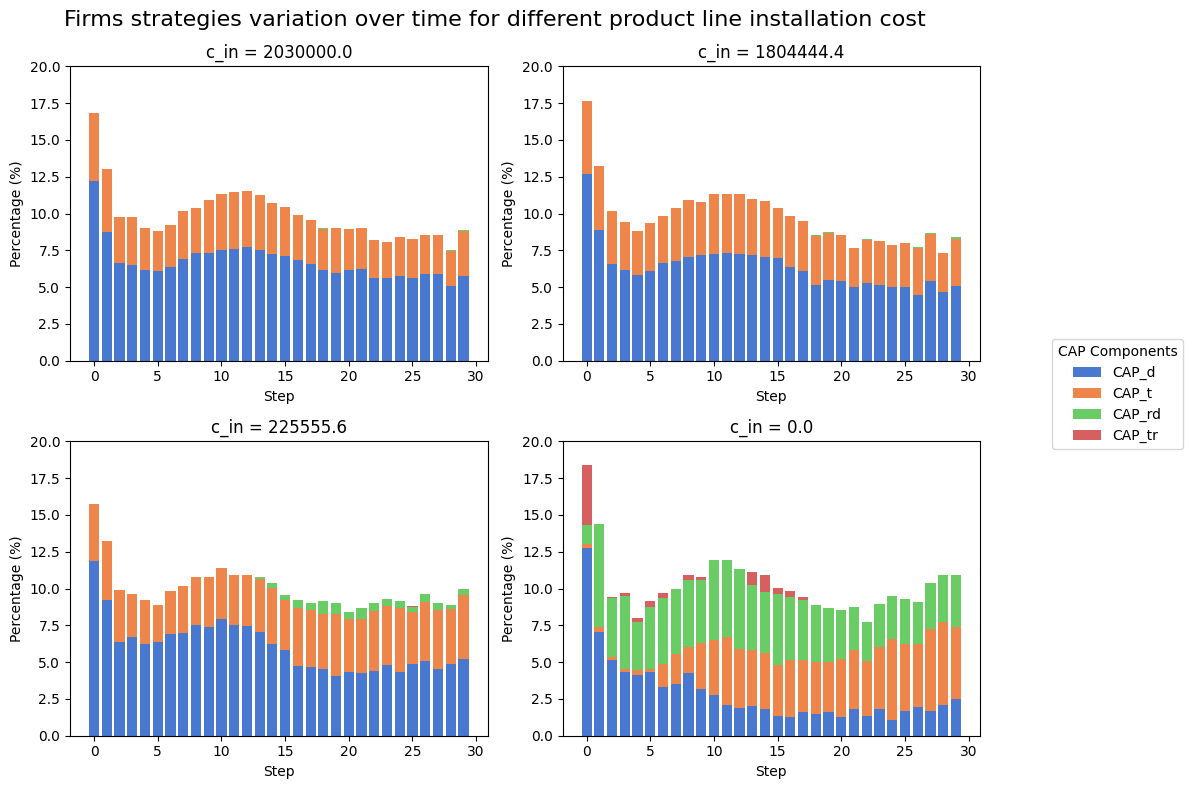

In [8]:
cb_c_in_test_model = pd.concat(c_in_test_model)
cb_c_in_test_agent = pd.concat(c_in_test_agent)

cb_c_in_test_model = cb_c_in_test_model.reset_index().rename(columns={'index':'Step'})
cb_c_in_test_model_grouped = cb_c_in_test_model.groupby(['c_in', 'Step'])
grouped_summary = cb_c_in_test_model_grouped[['CAP_d', 'CAP_t', 'CAP_rd','CAP_tr', 'source_0']].mean().reset_index()

grouped_summary_norm = grouped_summary.copy()
grouped_summary_norm[['CAP_d', 'CAP_t', 'CAP_rd','CAP_tr', 'source_0']] = grouped_summary_norm[['CAP_d', 'CAP_t', 'CAP_rd','CAP_tr', 'source_0']].div(grouped_summary[['CAP_d', 'CAP_t', 'CAP_rd','CAP_tr', 'source_0']].sum(axis=1), axis=0) * 100

grouped_summary_norm =  grouped_summary_norm.groupby(['c_in', 'Step']).mean().reset_index()
# Plotting
# Define a color palette
colors = sns.color_palette("muted")

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
# Plotting for each `c_in` separately with improved aesthetics
for c_in_value, ax in zip(grouped_summary_norm['c_in'].unique()[[9, 8, 1, 0]], axes):
    
    subset = grouped_summary_norm[grouped_summary_norm['c_in'] == c_in_value]
    bottoms = np.zeros(len(subset))
    
    for i, col in enumerate(['CAP_d', 'CAP_t', 'CAP_rd', 'CAP_tr']):
        ax.bar(subset['Step'], subset[col], bottom=bottoms, color=colors[i], label=col)
        bottoms += subset[col]
    ax.set_ylim(0, 20)  # Set the y-axis limit
    ax.set_xlabel('Step')
    ax.set_ylabel('Percentage (%)')
    ax.set_title(f'c_in = {round(c_in_value, 1)}')



# Move the legend outside the plot area and ensure it's not duplicated
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='CAP Components', bbox_to_anchor=(1.05, 0.5), loc='center left')

# Remove any empty subplots
for ax in axes[len(grouped_summary_norm['c_in'].unique()):]:
    fig.delaxes(ax)
fig.suptitle('Firms strategies variation over time for different product line installation cost', fontsize=16)
plt.tight_layout()
plt.show()

##### Plot for firm's strategies variation, c_in = 75185.2

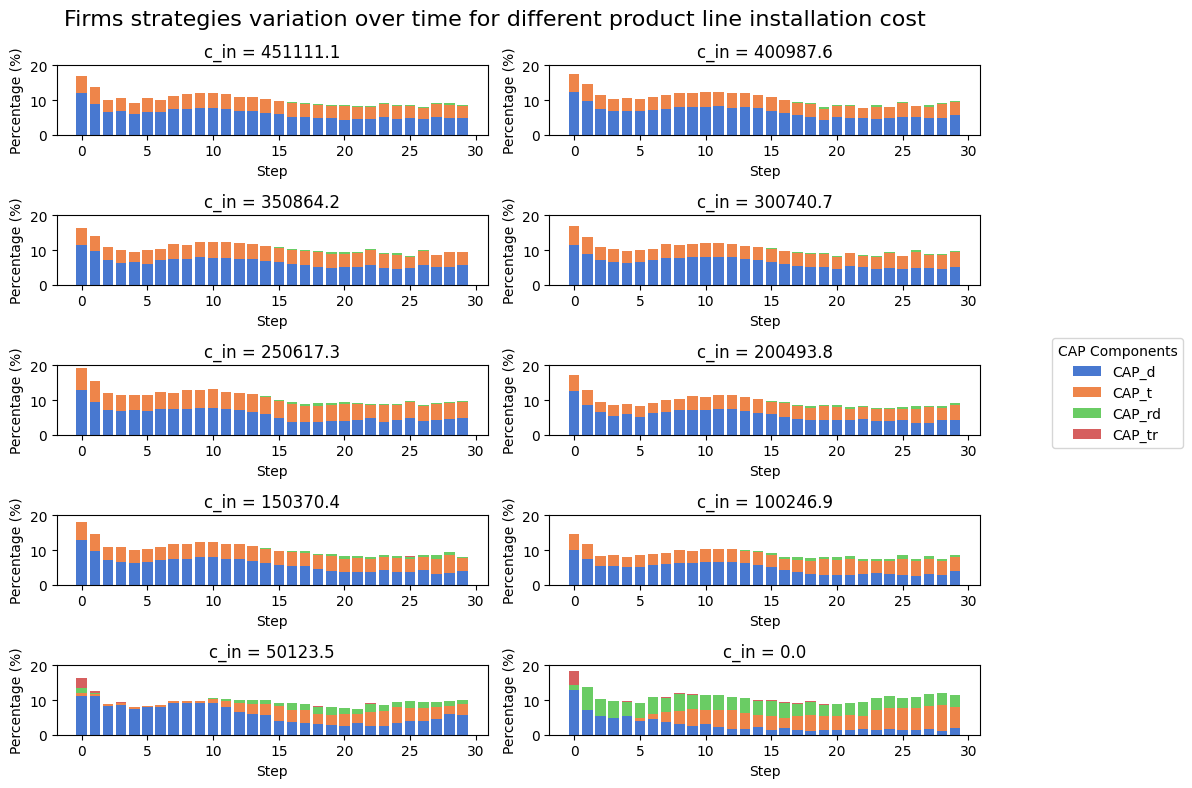

In [297]:
cb_c_in_test_model_sub = pd.concat(c_in_test_model_sub)

cb_c_in_test_model_sub = cb_c_in_test_model_sub.reset_index().rename(columns={'index':'Step'})
cb_c_in_test_model_grouped = cb_c_in_test_model_sub.groupby(['c_in', 'Step'])
grouped_summary = cb_c_in_test_model_grouped[['CAP_d', 'CAP_t', 'CAP_rd','CAP_tr', 'source_0']].mean().reset_index()

grouped_summary_norm = grouped_summary.copy()
grouped_summary_norm[['CAP_d', 'CAP_t', 'CAP_rd','CAP_tr', 'source_0']] = grouped_summary_norm[['CAP_d', 'CAP_t', 'CAP_rd','CAP_tr', 'source_0']].div(grouped_summary[['CAP_d', 'CAP_t', 'CAP_rd','CAP_tr', 'source_0']].sum(axis=1), axis=0) * 100

grouped_summary_norm =  grouped_summary_norm.groupby(['c_in', 'Step']).mean().reset_index()
# Plotting
# Define a color palette
colors = sns.color_palette("muted")

fig, axes = plt.subplots(5, 2, figsize=(10, 8))
axes = axes.flatten()
# Plotting for each `c_in` separately with improved aesthetics
for c_in_value, ax in zip(grouped_summary_norm['c_in'].unique()[::-1], axes):
    
    subset = grouped_summary_norm[grouped_summary_norm['c_in'] == c_in_value]
    bottoms = np.zeros(len(subset))
    
    for i, col in enumerate(['CAP_d', 'CAP_t', 'CAP_rd', 'CAP_tr']):
        ax.bar(subset['Step'], subset[col], bottom=bottoms, color=colors[i], label=col)
        bottoms += subset[col]
    ax.set_ylim(0, 20)  # Set the y-axis limit
    ax.set_xlabel('Step')
    ax.set_ylabel('Percentage (%)')
    ax.set_title(f'c_in = {round(c_in_value, 1)}')



# Move the legend outside the plot area and ensure it's not duplicated
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='CAP Components', bbox_to_anchor=(1.05, 0.5), loc='center left')

# Remove any empty subplots
for ax in axes[len(grouped_summary_norm['c_in'].unique()):]:
    fig.delaxes(ax)
fig.suptitle('Firms strategies variation over time for different product line installation cost', fontsize=16)
plt.tight_layout()
plt.show()

In [318]:
75185.2/2030000

0.037037044334975365

In [302]:
np.linspace(0, 2030000, 10)

array([      0.        ,  225555.55555556,  451111.11111111,
        676666.66666667,  902222.22222222, 1127777.77777778,
       1353333.33333333, 1578888.88888889, 1804444.44444444,
       2030000.        ])

In [303]:
np.linspace(0, 225555.55555556, 10)

array([     0.        ,  25061.72839506,  50123.45679012,  75185.18518519,
       100246.91358025, 125308.64197531, 150370.37037037, 175432.09876544,
       200493.8271605 , 225555.55555556])

##### PV diffusion, c_in

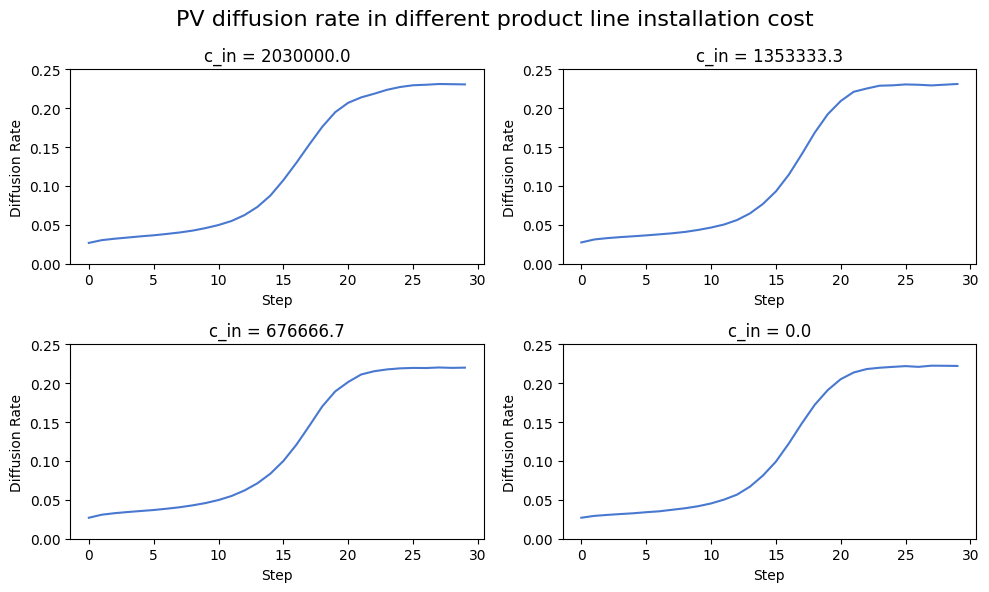

In [8]:
cb_c_in_test_model = pd.concat(c_in_test_model)

cb_c_in_test_model = cb_c_in_test_model.reset_index().rename(columns={'index':'Step'})
cb_c_in_test_model_grouped = cb_c_in_test_model.groupby(['c_in', 'Step'])
grouped_summary = cb_c_in_test_model_grouped['diffusion rate'].mean().reset_index()

# Plotting
# Define a color palette
colors = sns.color_palette("muted")

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

# Plotting for each `c_in` separately with improved aesthetics
for c_in_value, ax in zip(grouped_summary['c_in'].unique()[[9, 6, 3, 0]], axes):
    
    # Subset the data for the current `c_in_value`
    subset = grouped_summary[grouped_summary['c_in'] == c_in_value]
    
    # Plot the line chart
    ax.plot(subset['Step'], subset['diffusion rate'], color=colors[0])
    
    # Set the title and labels
    ax.set_title(f'c_in = {round(c_in_value, 1)}')
    ax.set_xlabel('Step')
    ax.set_ylabel('Diffusion Rate')
    
    # Optionally set consistent y-axis limits
    ax.set_ylim(0, 0.25)  # Adjust according to data range

fig.suptitle('PV diffusion rate in different product line installation cost', fontsize=16)
# Adjust the layout to ensure everything fits
plt.tight_layout()
# Show the plot
plt.show()

##### Plot for firm's asset

In [10]:
import matplotlib.ticker as mticker

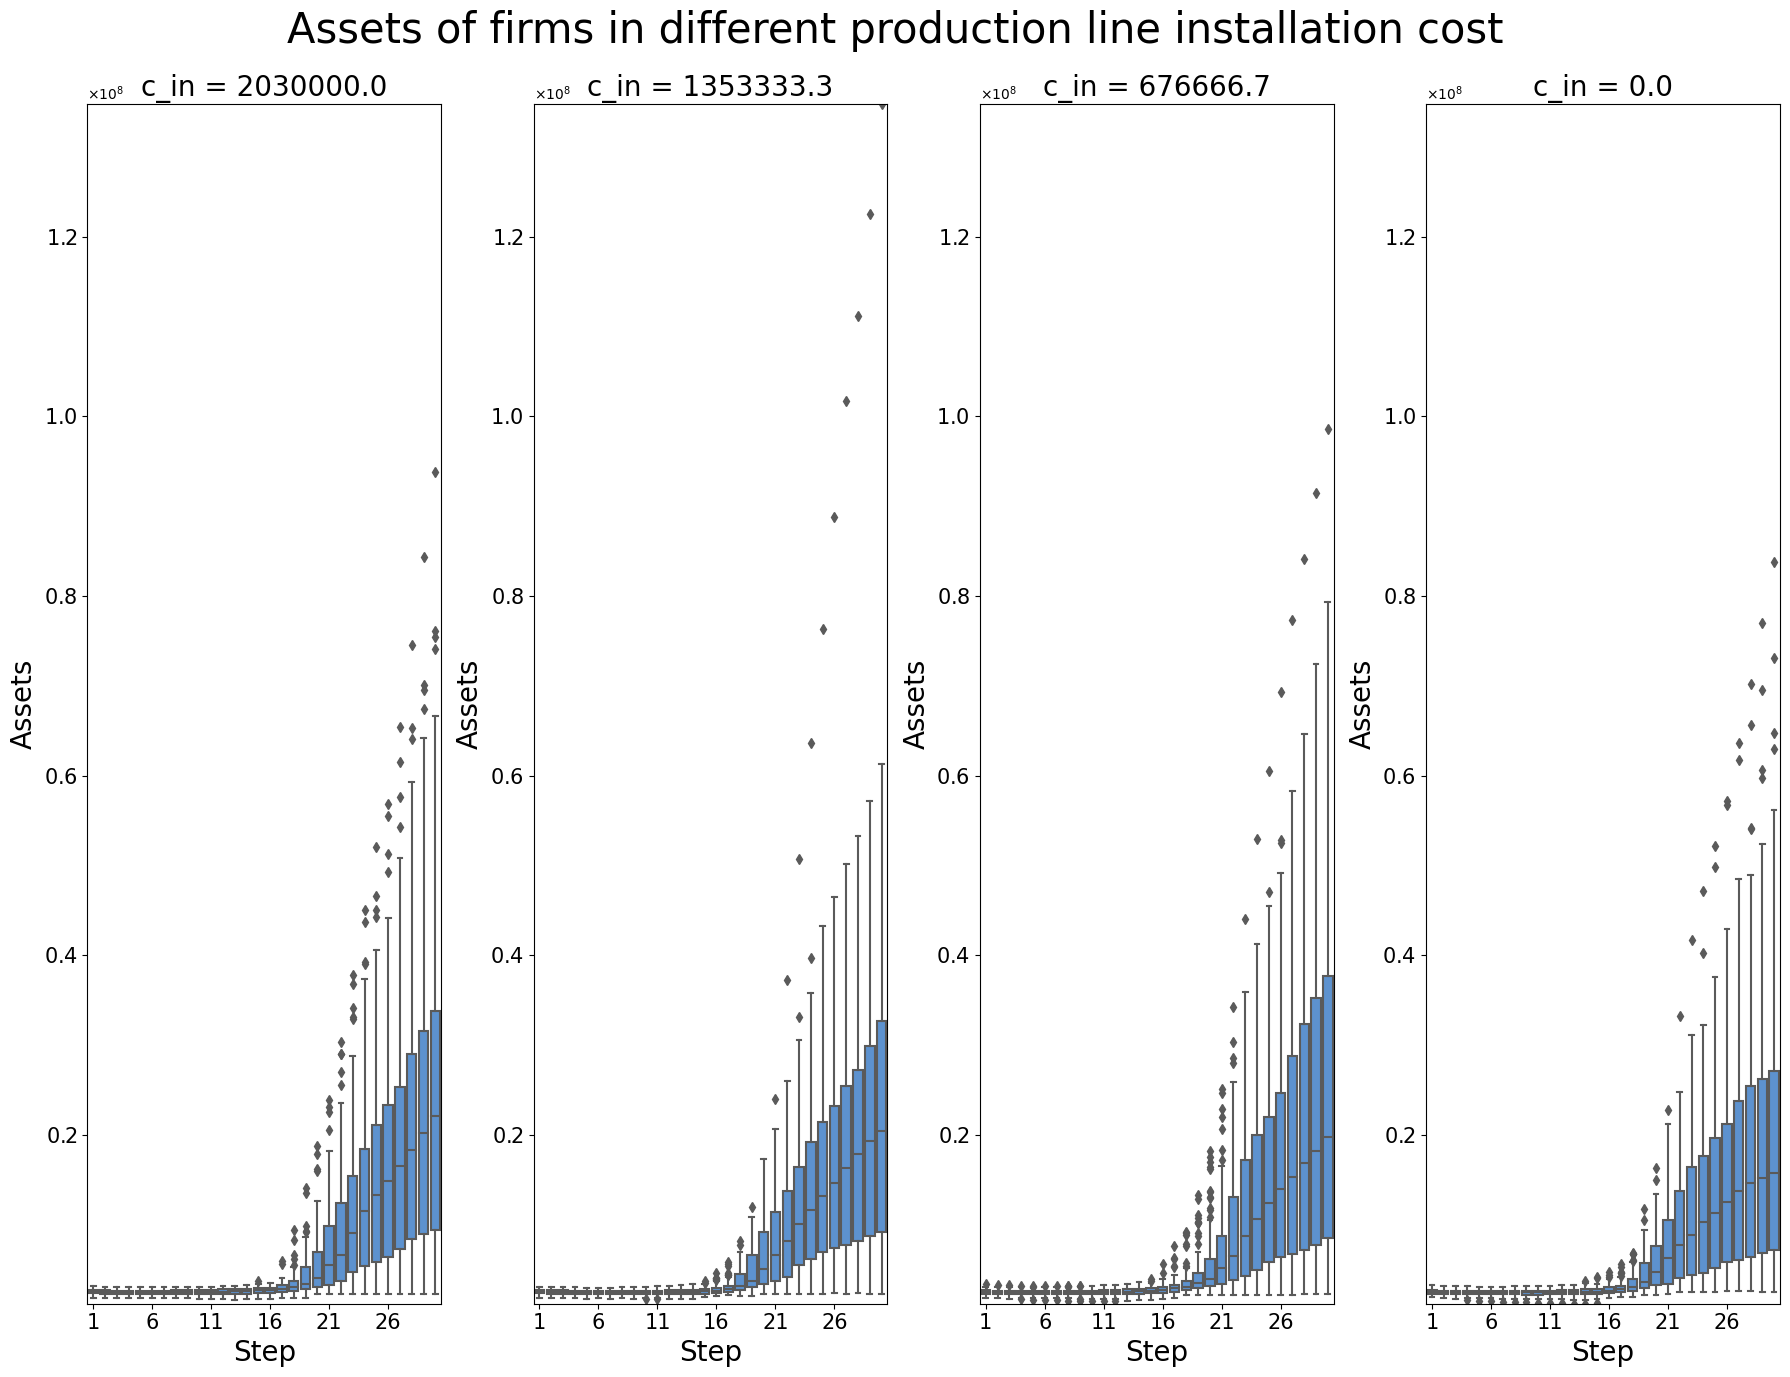

In [13]:
cb_c_in_test_agent = pd.concat(c_in_test_agent)
cb_c_in_test_agent = cb_c_in_test_agent.reset_index().rename(columns={'index':'Step'})

cb_c_in_test_agent_grouped = cb_c_in_test_agent.groupby(['c_in', 'Step', 'AgentID']).mean().reset_index()

y_min = min(cb_c_in_test_agent_grouped['Assets'])
y_max = max(cb_c_in_test_agent_grouped['Assets'])
# Plotting
# Define a color palette
colors = "#4a90e2"
xticks = list(range(0, int(cb_c_in_test_agent['Step'].max()), 5))

fig, axes = plt.subplots(1, 4, figsize=(18, 14))
axes = axes.flatten()
# Plotting for each `c_in` separately with improved aesthetics
for c_in_value, ax in zip(cb_c_in_test_agent['c_in'].unique()[[9, 6, 3, 0]], axes):
    
    # Subset the data for the current `c_in_value`
    subset = cb_c_in_test_agent_grouped[cb_c_in_test_agent_grouped['c_in'] == c_in_value]
    
    # Plot the scatter plot for Asset over time (Step)
    sns.boxplot(x = 'Step', y = 'Assets', data = subset, ax=ax, color = colors)
    
    ax.set_xticks(xticks, fontsize = 20)
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    # Set the title and labels
    ax.set_title(f'c_in = {round(c_in_value, 1)}', fontsize = 20)
    ax.set_xlabel('Step', fontsize = 20)
    ax.set_ylabel('Assets', fontsize = 20)

    #ax.xaxis.set_tick_params(labelrotation=90)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    
    
    # Optionally set consistent y-axis limits
    ax.set_ylim(y_min, y_max)  # Adjust according to data range
    #ax.set_ylim(0, 40000000)  # Adjust according to data range

fig.suptitle('Assets of firms in different production line installation cost', fontsize=30)
# Adjust the layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()

##### Plots for firm's income and profit

Income

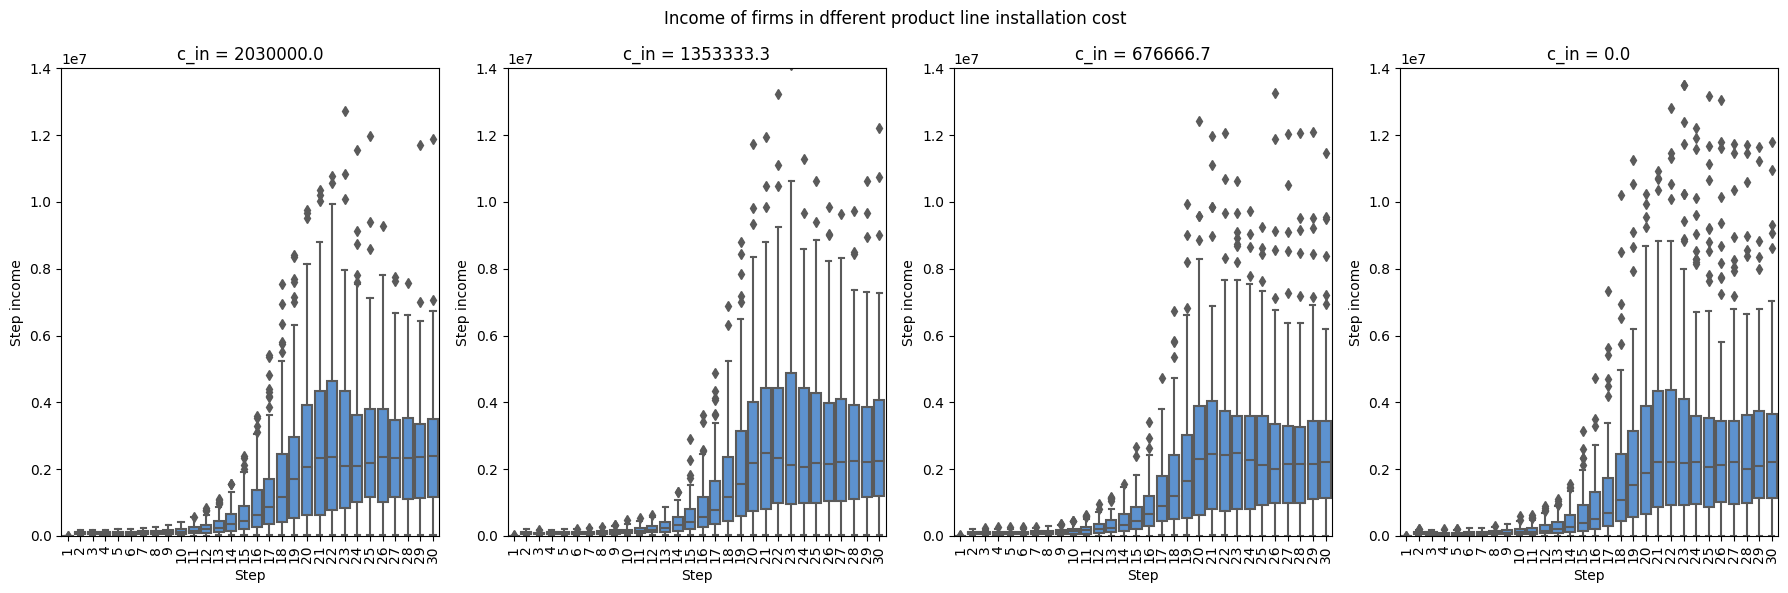

In [10]:
cb_c_in_test_agent = pd.concat(c_in_test_agent)
cb_c_in_test_agent = cb_c_in_test_agent.reset_index().rename(columns={'index':'Step'})

cb_c_in_test_agent_grouped = cb_c_in_test_agent.groupby(['c_in', 'Step', 'AgentID']).mean().reset_index()
# Plotting
# Define a color palette
colors = "#4a90e2"

fig, axes = plt.subplots(1, 4, figsize=(18, 6))
axes = axes.flatten()
# Plotting for each `c_in` separately with improved aesthetics
for c_in_value, ax in zip(cb_c_in_test_agent['c_in'].unique()[[9, 6, 3, 0]], axes):
    
    # Subset the data for the current `c_in_value`
    subset = cb_c_in_test_agent_grouped[cb_c_in_test_agent_grouped['c_in'] == c_in_value]
    
    # Plot the scatter plot for Asset over time (Step)
    sns.boxplot(x = 'Step', y = 'Step income', data = subset, ax=ax, color = colors)
    
    
    # Set the title and labels
    ax.set_title(f'c_in = {round(c_in_value, 1)}')
    ax.set_xlabel('Step')
    ax.set_ylabel('Step income')

    ax.xaxis.set_tick_params(labelrotation=90)
    
    # Optionally set consistent y-axis limits
    ax.set_ylim(0, 14000000)  # Adjust according to data range

fig.suptitle('Income of firms in dfferent product line installation cost')
# Adjust the layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()

Profit

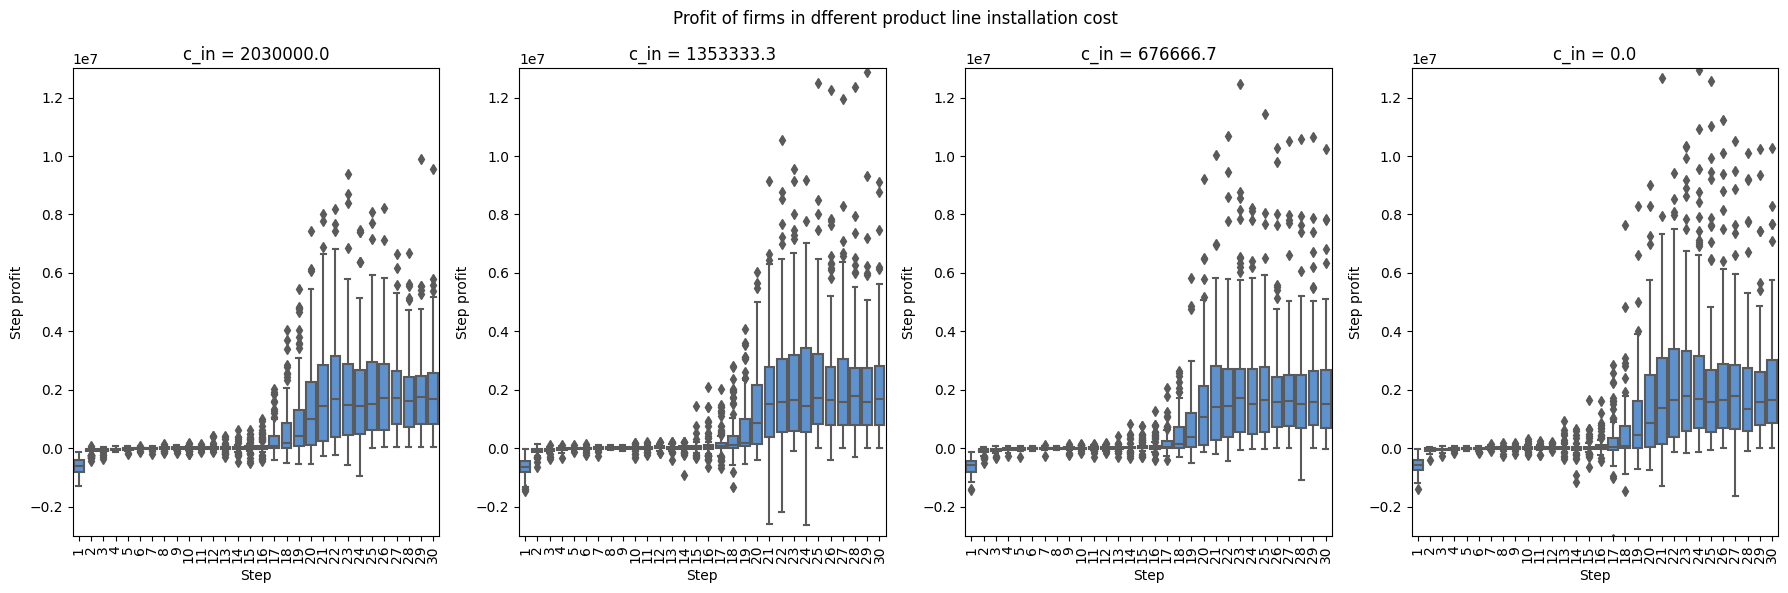

In [11]:
cb_c_in_test_agent = pd.concat(c_in_test_agent)
cb_c_in_test_agent = cb_c_in_test_agent.reset_index().rename(columns={'index':'Step'})

cb_c_in_test_agent_grouped = cb_c_in_test_agent.groupby(['c_in', 'Step', 'AgentID']).mean().reset_index()
# Plotting
# Define a color palette
colors = "#4a90e2"

fig, axes = plt.subplots(1, 4, figsize=(18, 6))
axes = axes.flatten()
# Plotting for each `c_in` separately with improved aesthetics
for c_in_value, ax in zip(cb_c_in_test_agent['c_in'].unique()[[9, 6, 3, 0]], axes):
    
    # Subset the data for the current `c_in_value`
    subset = cb_c_in_test_agent_grouped[cb_c_in_test_agent_grouped['c_in'] == c_in_value]
    
    # Plot the scatter plot for Asset over time (Step)
    sns.boxplot(x = 'Step', y = 'Step profit', data = subset, ax=ax, color = colors)
    
    
    # Set the title and labels
    ax.set_title(f'c_in = {round(c_in_value, 1)}')
    ax.set_xlabel('Step')
    ax.set_ylabel('Step profit')

    ax.xaxis.set_tick_params(labelrotation=90)
    
    # Optionally set consistent y-axis limits
    ax.set_ylim(-3000000, 13000000)  # Adjust according to data range

fig.suptitle('Profit of firms in dfferent product line installation cost')
# Adjust the layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()

Innovation profit

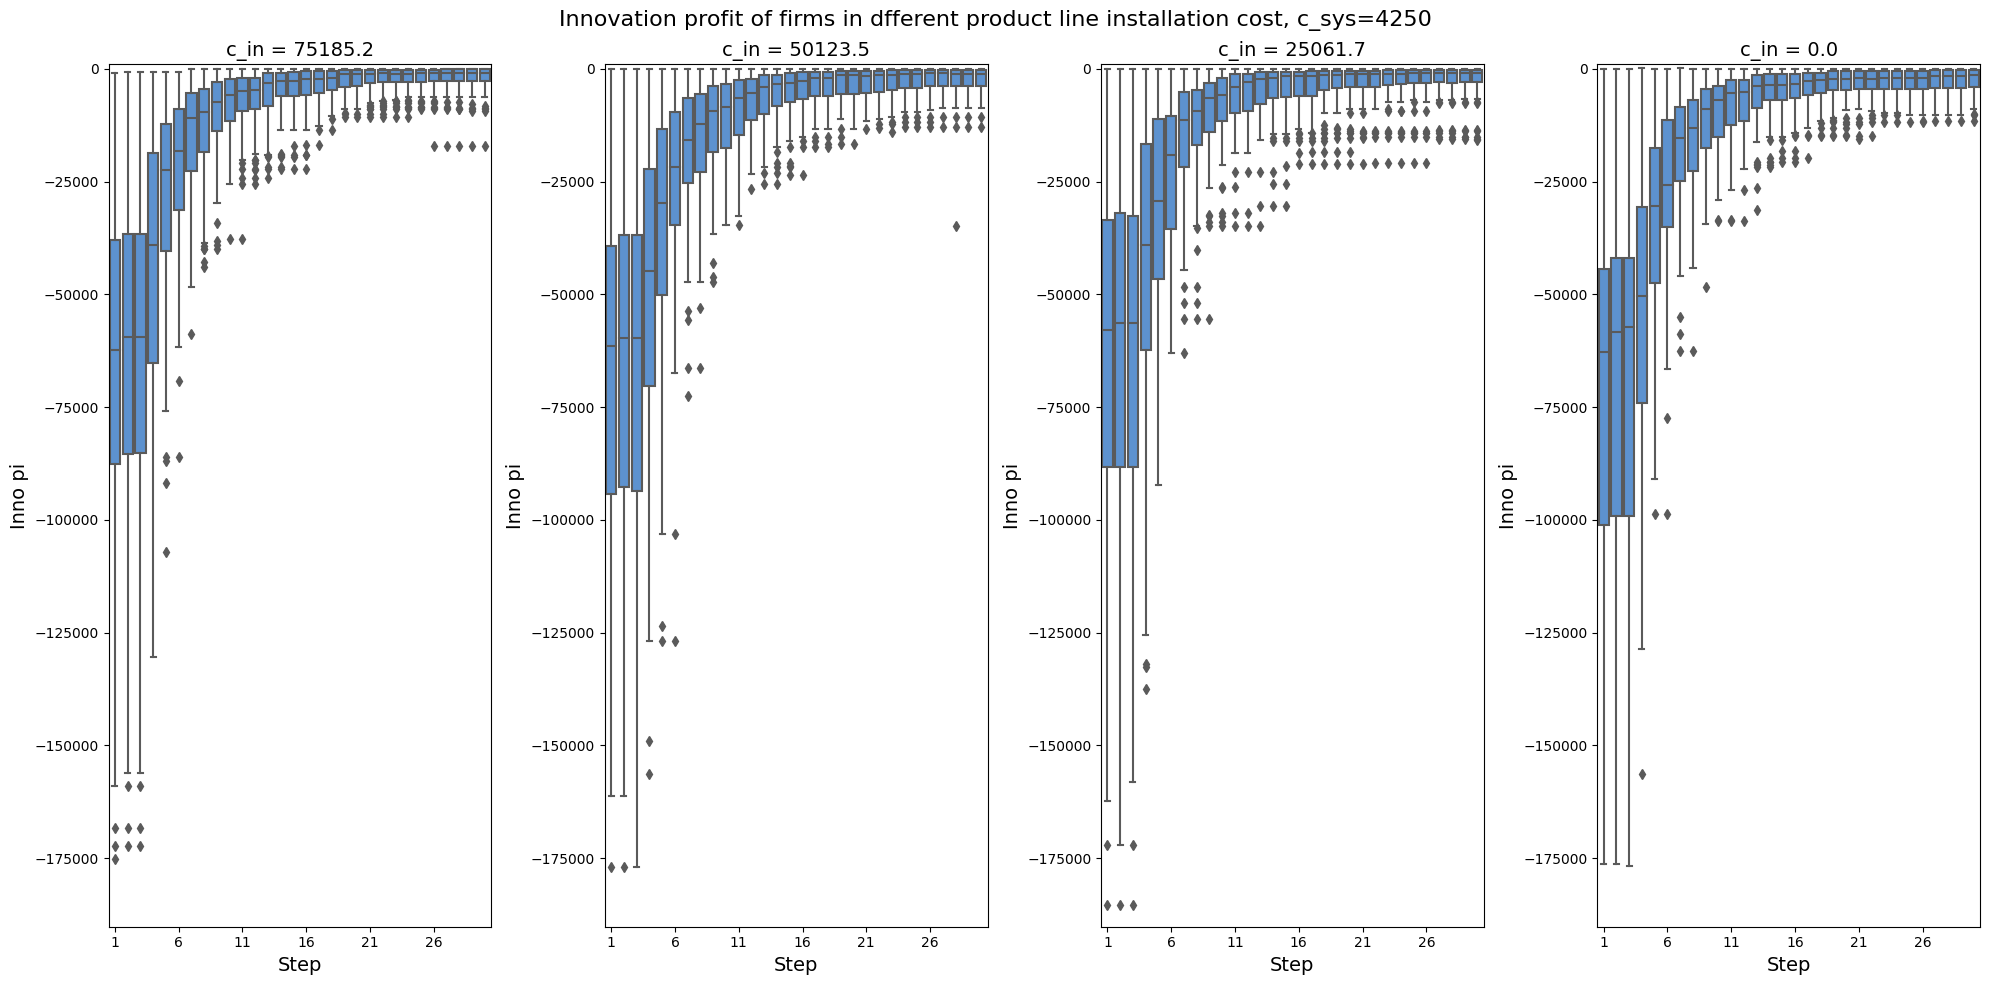

In [270]:
cb_c_in_test_agent_sub = pd.concat(c_in_test_agent_sub)
cb_c_in_test_agent_sub = cb_c_in_test_agent_sub.reset_index().rename(columns={'index':'Step'})

cb_c_in_test_agent_sub_grouped = cb_c_in_test_agent_sub.groupby(['c_in', 'Step', 'AgentID']).mean().reset_index()

y_min = min(cb_c_sys_test_agent_grouped['Inno pi'])
y_max = max(cb_c_sys_test_agent_grouped['Inno pi'])
# Plotting
# Define a color palette
colors = "#4a90e2"
xticks = list(range(0, int(cb_c_in_test_agent_sub['Step'].max()), 5))  # 例如，每5个Step显示一次

fig, axes = plt.subplots(1, 4, figsize=(20, 10))
axes = axes.flatten()
# Plotting for each `c_in` separately with improved aesthetics
for c_in_value, ax in zip(cb_c_in_test_agent_sub['c_in'].unique()[[9, 6, 3, 0]], axes):
    
    # Subset the data for the current `c_in_value`
    subset = cb_c_in_test_agent_sub_grouped[cb_c_in_test_agent_sub_grouped['c_in'] == c_in_value]
    
    # Plot the scatter plot for Asset over time (Step)
    sns.boxplot(x = 'Step', y = 'Inno pi', data = subset, ax=ax, color = colors)
    
    
    # Set the title and labels
    ax.set_xticks(xticks)
    ax.set_title(f'c_in = {round(c_in_value, 1)}', fontsize=14)
    ax.set_xlabel('Step', fontsize=14)
    ax.set_ylabel('Inno pi', fontsize=14)

    #ax.xaxis.set_tick_params(labelrotation=90)
    
    # Optionally set consistent y-axis limits
    ax.set_ylim(y_min, 1000)  # Adjust according to data range

fig.suptitle('Innovation profit of firms in dfferent product line installation cost, c_sys=4250', fontsize=16)
# Adjust the layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()

max production line product quality

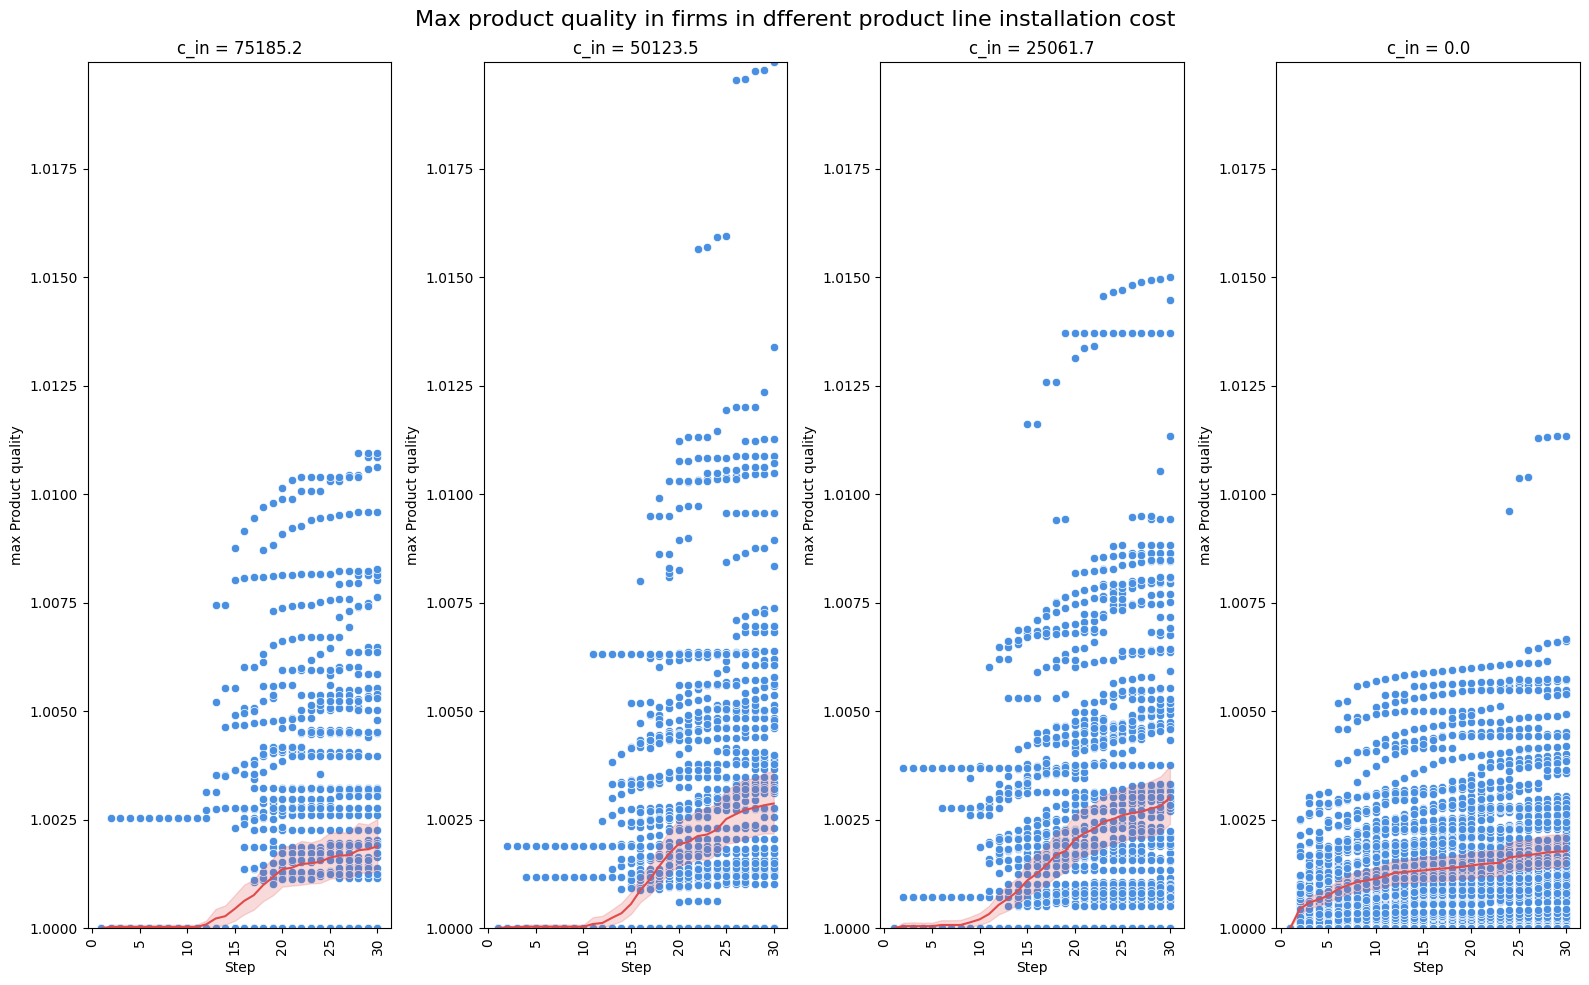

In [255]:
cb_c_in_test_agent_sub = pd.concat(c_in_test_agent_sub)
cb_c_in_test_agent_sub = cb_c_in_test_agent_sub.reset_index().rename(columns={'index':'Step'})

cb_c_in_test_agent_sub_grouped = cb_c_in_test_agent_sub.groupby(['c_in', 'Step', 'AgentID']).mean().reset_index()

y_min = min(cb_c_in_test_agent_sub_grouped['max Product quality'])
y_max = max(cb_c_in_test_agent_sub_grouped['max Product quality'])
# Plotting
# Define a color palette
colors = ["#4a90e2", "#e24a4a"] 

fig, axes = plt.subplots(1, 4, figsize=(16, 10))
axes = axes.flatten()
# Plotting for each `c_in` separately with improved aesthetics
for c_in_value, ax in zip(cb_c_in_test_agent_sub['c_in'].unique()[[9, 6, 3, 0]], axes):
    
    # Subset the data for the current `c_in_value`
    subset = cb_c_in_test_agent_sub_grouped[cb_c_in_test_agent_sub_grouped['c_in'] == c_in_value]
    
    # Plot the scatter plot for Asset over time (Step)
    sns.scatterplot(x = 'Step', y = 'max Product quality', data = subset, ax=ax, color = colors[0])
    sns.lineplot(x = 'Step', y = 'max Product quality', data = subset, ax=ax, color = colors[1])

    # Set the title and labels
    ax.set_title(f'c_in = {round(c_in_value, 1)}')
    ax.set_xlabel('Step')
    ax.set_ylabel('max Product quality')

    ax.xaxis.set_tick_params(labelrotation=90)
    
    # Optionally set consistent y-axis limits
    ax.set_ylim(y_min, y_max)  # Adjust according to data range

fig.suptitle('Max product quality in firms in dfferent product line installation cost', fontsize=16)
# Adjust the layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()

#### Model for PV system installation cost (c_sys) variation

In [44]:
c_sys_test_model = []
c_sys_test_agent = []
#c_in_values = np.linspace(0, 2030000, 5)
#c_in = 2030000 ### original value
c_in = 75185.2
c_sys_values = np.linspace(0, 4250, 10)
#c_sys = 4250

### 5 c_in values
for c_sys in c_sys_values:
        ### 15 runs to remove randomness
        for run in range(20):
                model = SimModel(100, 70, c_in, c_sys, 10, 10, 42)
                for i in range(30): # the number of steps
                        model.step()
                ### store the data in each loop
                model_data = model.datacollector.get_model_vars_dataframe()
                agent_data = model.datacollector.get_agent_vars_dataframe().reindex()
                model_data['run'] = run
                agent_data['run'] = run
                model_data['c_sys'] = c_sys
                agent_data['c_sys'] = c_sys
                ### add the data to the total dataset
                c_sys_test_model.append(model_data)
                c_sys_test_agent.append(agent_data)
                #Grid_container.append(list(model.grid.coord_iter()))


##### Plot for stratgies variation

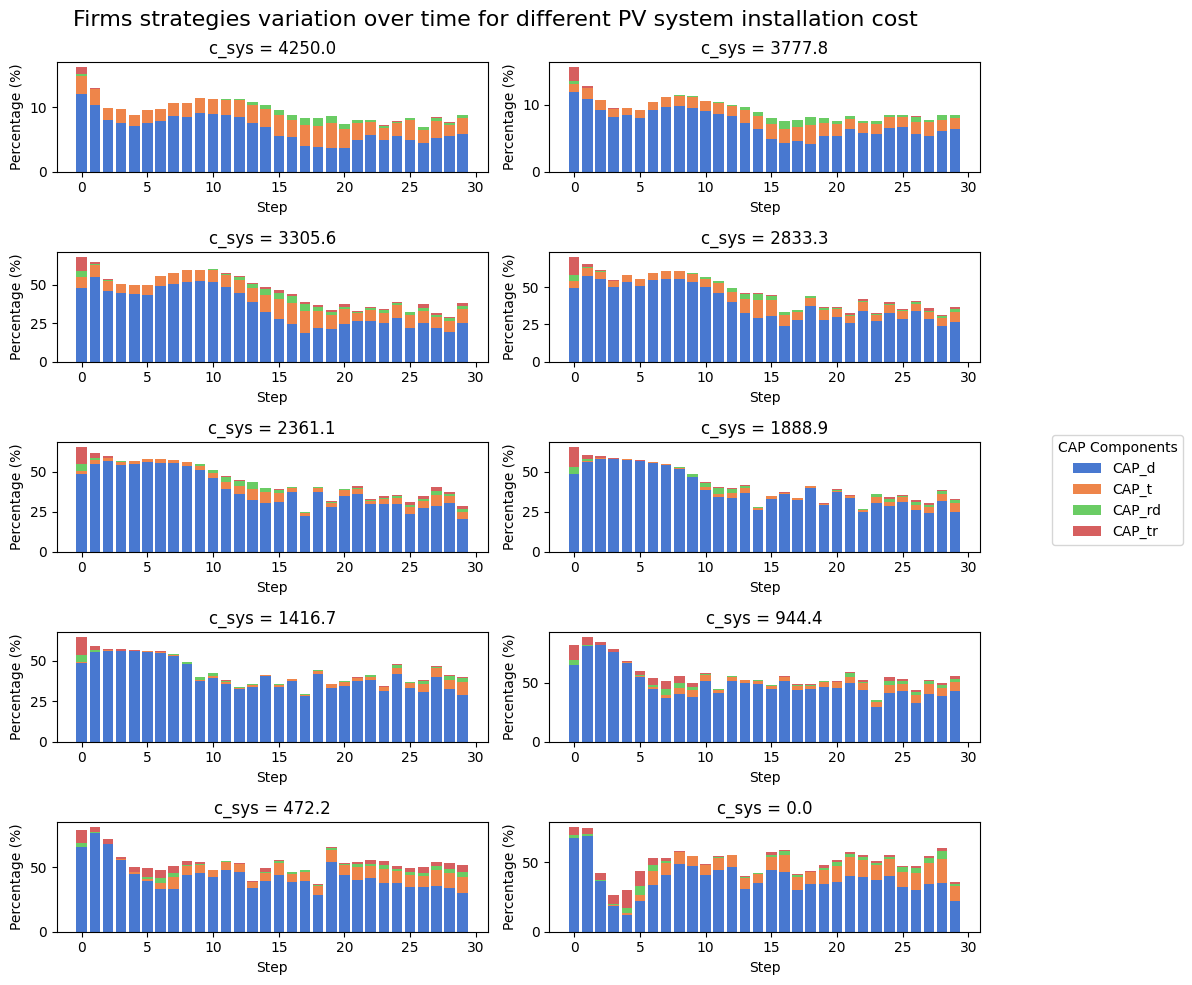

In [45]:
cb_c_sys_test_model = pd.concat(c_sys_test_model)
cb_c_sys_test_agent = pd.concat(c_sys_test_agent)

cb_c_sys_test_model = cb_c_sys_test_model.reset_index().rename(columns={'index':'Step'})
cb_c_sys_test_model_grouped = cb_c_sys_test_model.groupby(['c_sys', 'Step'])
grouped_summary = cb_c_sys_test_model_grouped[['CAP_d', 'CAP_t', 'CAP_rd','CAP_tr', 'source_0']].mean().reset_index()

grouped_summary_norm = grouped_summary.copy()
grouped_summary_norm[['CAP_d', 'CAP_t', 'CAP_rd','CAP_tr', 'source_0']] = grouped_summary_norm[['CAP_d', 'CAP_t', 'CAP_rd','CAP_tr', 'source_0']].div(grouped_summary[['CAP_d', 'CAP_t', 'CAP_rd','CAP_tr', 'source_0']].sum(axis=1), axis=0) * 100

grouped_summary_norm =  grouped_summary_norm.groupby(['c_sys', 'Step']).mean().reset_index()
# Plotting
# Define a color palette
colors = sns.color_palette("muted")

fig, axes = plt.subplots(5, 2, figsize=(10, 10))
axes = axes.flatten()
# Plotting for each `c_sys` separately with improved aesthetics
for c_sys_value, ax in zip(grouped_summary_norm['c_sys'].unique()[::-1], axes):
    
    subset = grouped_summary_norm[grouped_summary_norm['c_sys'] == c_sys_value]
    bottoms = np.zeros(len(subset))
    
    for i, col in enumerate(['CAP_d', 'CAP_t', 'CAP_rd', 'CAP_tr']):
        ax.bar(subset['Step'], subset[col], bottom=bottoms, color=colors[i], label=col)
        bottoms += subset[col]
    #ax.set_ylim(0, 80)  # Set the y-axis limit
    ax.set_xlabel('Step')
    ax.set_ylabel('Percentage (%)')
    ax.set_title(f'c_sys = {round(c_sys_value, 1)}')



# Move the legend outside the plot area and ensure it's not duplicated
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='CAP Components', bbox_to_anchor=(1.05, 0.5), loc='center left')

# Remove any empty subplots
for ax in axes[len(grouped_summary_norm['c_sys'].unique()):]:
    fig.delaxes(ax)
fig.suptitle('Firms strategies variation over time for different PV system installation cost', fontsize=16)
plt.tight_layout()
plt.show()

#### PV diffusion, c_sys

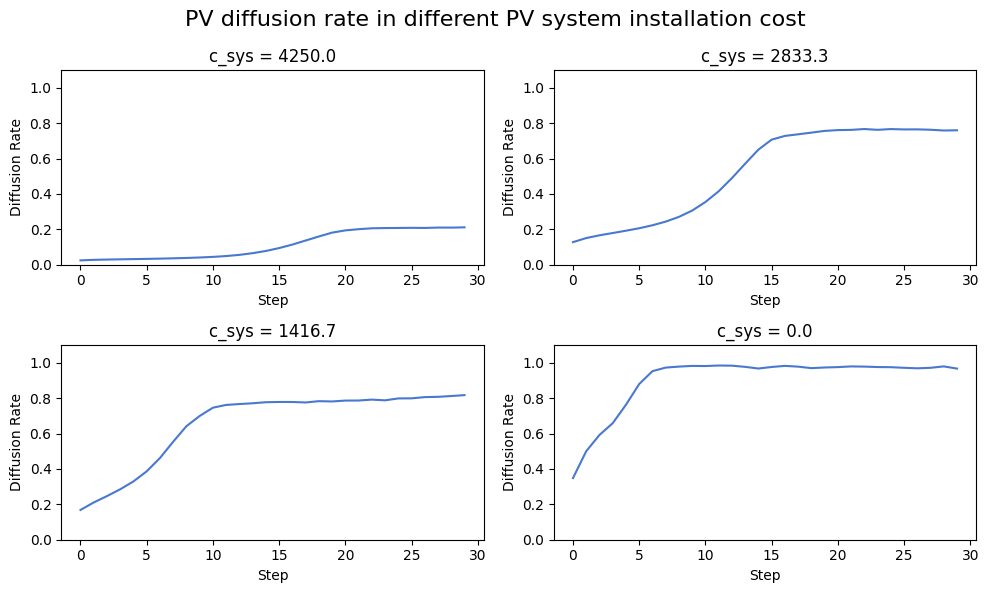

In [46]:
cb_c_sys_test_model = pd.concat(c_sys_test_model)

cb_c_sys_test_model = cb_c_sys_test_model.reset_index().rename(columns={'index':'Step'})
cb_c_sys_test_model_grouped = cb_c_sys_test_model.groupby(['c_sys', 'Step'])
grouped_summary = cb_c_sys_test_model_grouped['diffusion rate'].mean().reset_index()

# Plotting
# Define a color palette
colors = sns.color_palette("muted")

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

# Plotting for each `c_in` separately with improved aesthetics
for c_sys_value, ax in zip(grouped_summary['c_sys'].unique()[[9, 6, 3, 0]], axes):
    
    # Subset the data for the current `c_in_value`
    subset = grouped_summary[grouped_summary['c_sys'] == c_sys_value]
    
    # Plot the line chart
    ax.plot(subset['Step'], subset['diffusion rate'], color=colors[0])
    
    # Set the title and labels
    ax.set_title(f'c_sys = {round(c_sys_value, 1)}')
    ax.set_xlabel('Step')
    ax.set_ylabel('Diffusion Rate')
    
    # Optionally set consistent y-axis limits
    ax.set_ylim(0, 1.1)  # Adjust according to data range
fig.suptitle('PV diffusion rate in different PV system installation cost', fontsize=16)
# Adjust the layout to ensure everything fits
plt.tight_layout()
# Show the plot
plt.show()

#### Plots for firm's financial condition

##### Plots for firm's asset

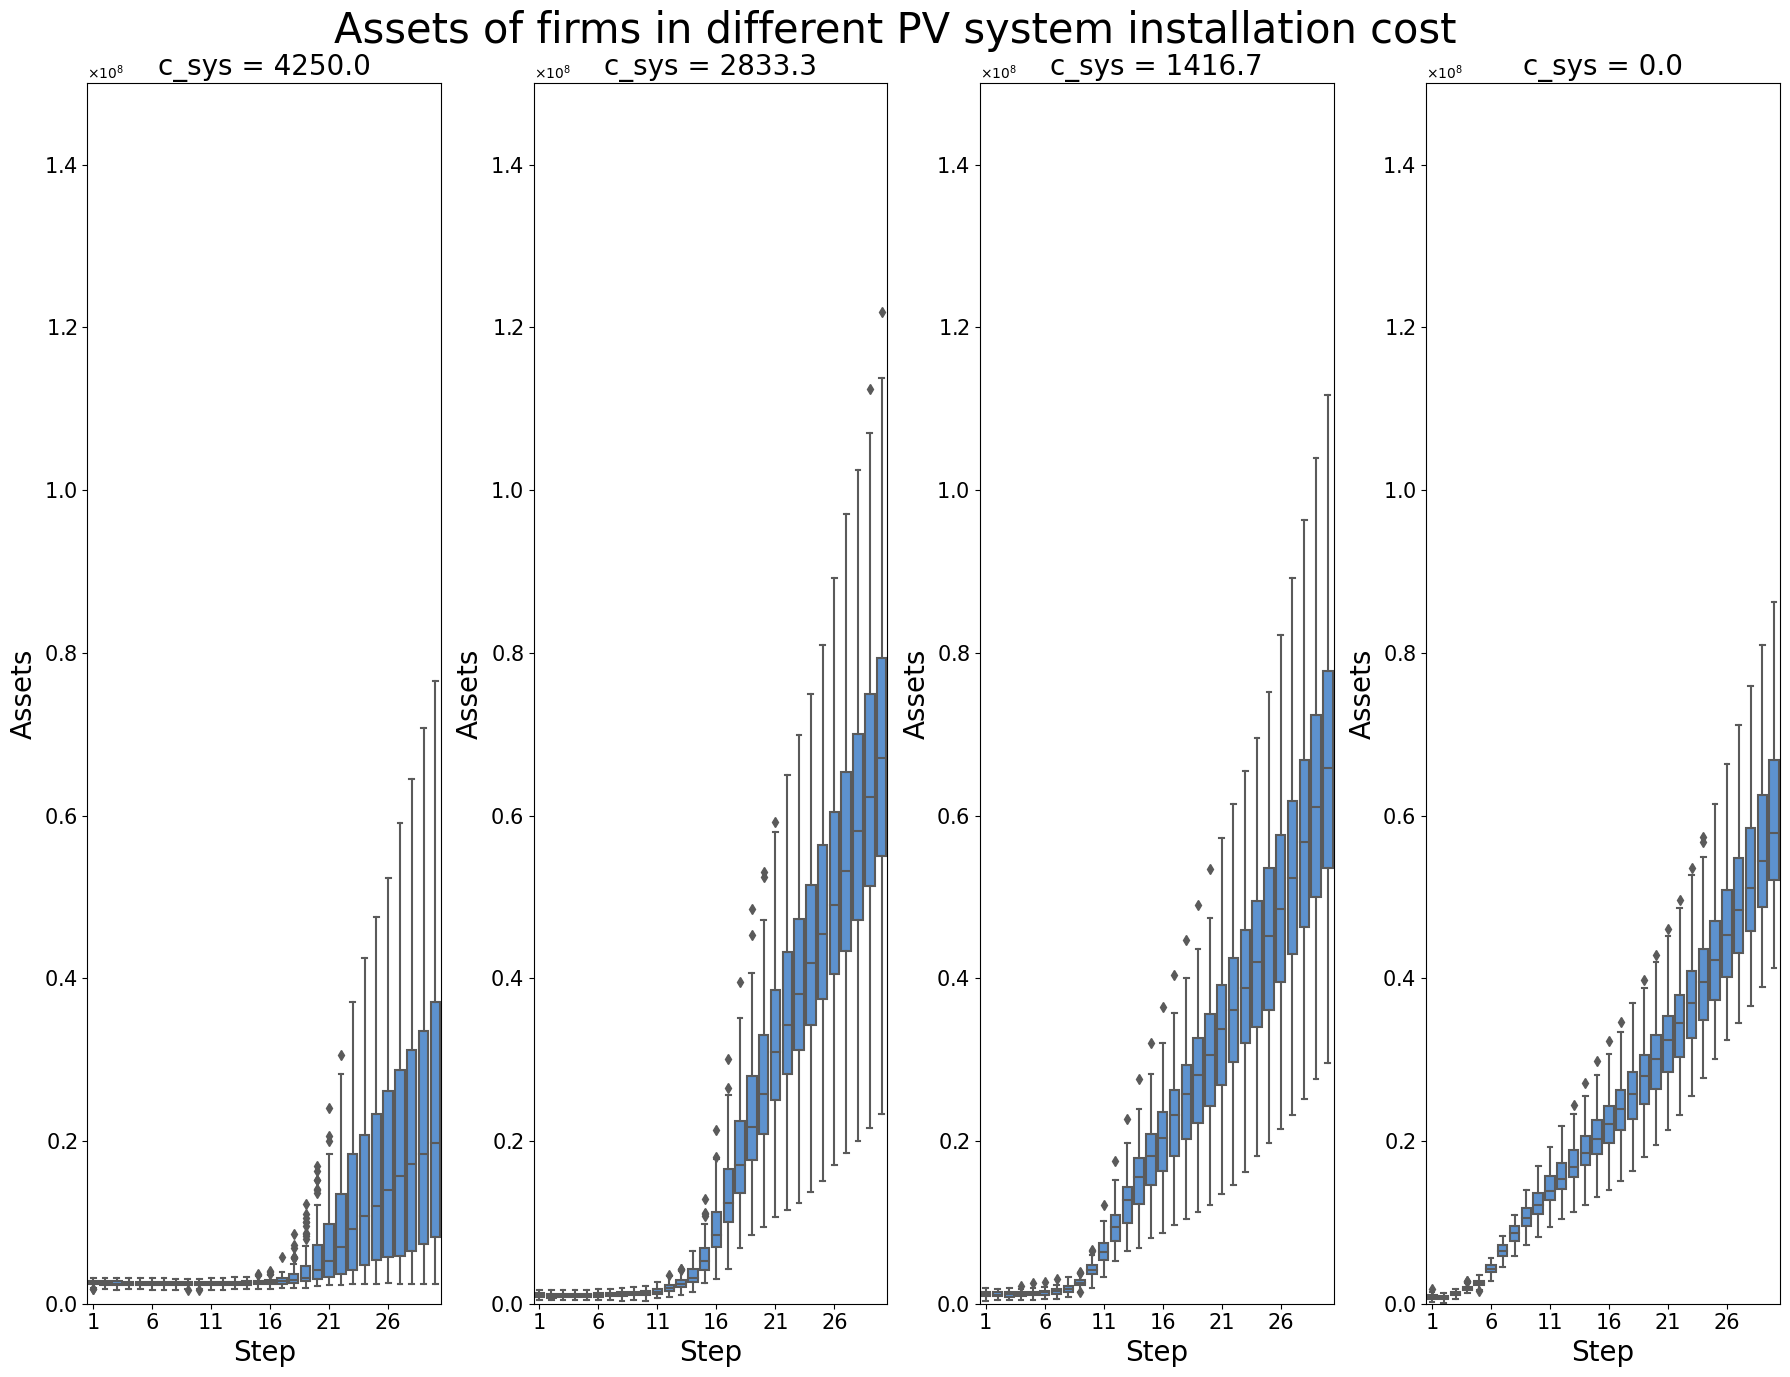

In [25]:
cb_c_sys_test_agent = pd.concat(c_sys_test_agent)
cb_c_sys_test_agent = cb_c_sys_test_agent.reset_index().rename(columns={'index':'Step'})

cb_c_sys_test_agent_grouped = cb_c_sys_test_agent.groupby(['c_sys', 'Step', 'AgentID']).mean().reset_index()

y_min = min(cb_c_sys_test_agent_grouped['Assets'])
y_max = max(cb_c_sys_test_agent_grouped['Assets'])
# Plotting
# Define a color palette
colors = "#4a90e2"
xticks = list(range(0, int(cb_c_sys_test_agent['Step'].max()), 5))

fig, axes = plt.subplots(1, 4, figsize=(18, 14))
axes = axes.flatten()
# Plotting for each `c_sys` separately with improved aesthetics
for c_sys_value, ax in zip(cb_c_sys_test_agent['c_sys'].unique()[[9, 6, 3, 0]], axes):
    
    # Subset the data for the current `c_in_value`
    subset = cb_c_sys_test_agent_grouped[cb_c_sys_test_agent_grouped['c_sys'] == c_sys_value]
    
    # Plot the scatter plot for Asset over time (Step)
    sns.boxplot(x = 'Step', y = 'Assets', data = subset, ax=ax, color = colors)
    
    #ax.set_ylim(0, 310000000)
    ax.set_xticks(xticks, fontsize = 20)
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    # Set the title and labels
    ax.set_title(f'c_sys = {round(c_sys_value, 1)}', fontsize = 20)
    ax.set_xlabel('Step', fontsize = 20)
    ax.set_ylabel('Assets', fontsize = 20)

    #ax.xaxis.set_tick_params(labelrotation=90)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    
    # Optionally set consistent y-axis limits
    ax.set_ylim(y_min, y_max)  # Adjust according to data range
    #ax.set_ylim(0, 150000000)  # Adjust according to data range

fig.suptitle('Assets of firms in different PV system installation cost', fontsize = 30)
# Adjust the layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()

##### Impact of decisions on assets

In [50]:
cb_c_sys_test_agent.columns

Index(['Step', 'AgentID', 'Assets', 'AccInnocost', 'C_i', 'profit_pi',
       'R_tr_i', 'P_t_i', 'C_in', 'C_op', 'C_p', 'P_t_c', 'C_sys', 'C_om',
       'R_tr_c', 'R_rd', 'percent_of_PV_power', 'Electricity demand',
       'PV power (kWh)', 'Community PV installed', 'Community p_e',
       'Residences', 'PV_Source', 'Source_ID', 'Inno_step', 'K_capital',
       'Global max quality', 'max Inno quality', 'min Inno quality',
       'max Product quality', 'min Product quality', 'Lab product number',
       'Prod line product number', 'Production cost (c_p)', 'Product price',
       'Tech_tr_price', 'Inno prod number', 'Firm_type', 'Firm_type_change',
       'Inno_cost_percent', 'PositionX', 'PositionY', 'Position',
       'Electricity price', 'Supply community ID', 'Supply community Numbers',
       'Supply community p_e', 'Inno pi', 'Step income', 'Step profit', 'run',
       'c_sys'],
      dtype='object')

In [157]:
cb_c_sys_test_agent.columns

Index(['Step', 'AgentID', 'Assets', 'AccInnocost', 'C_i', 'profit_pi',
       'R_tr_i', 'P_t_i', 'C_in', 'C_op', 'C_p', 'P_t_c', 'C_sys', 'C_om',
       'R_tr_c', 'R_rd', 'percent_of_PV_power', 'Electricity demand',
       'PV power (kWh)', 'Community PV installed', 'Community p_e',
       'Residences', 'PV_Source', 'Source_ID', 'Inno_step', 'K_capital',
       'Global max quality', 'max Inno quality', 'min Inno quality',
       'max Product quality', 'min Product quality', 'Lab product number',
       'Prod line product number', 'Production cost (c_p)', 'Product price',
       'Tech_tr_price', 'Inno prod number', 'Firm_type', 'Firm_type_change',
       'Inno_cost_percent', 'PositionX', 'PositionY', 'Position',
       'Electricity price', 'Supply community ID', 'Supply community Numbers',
       'Supply community p_e', 'Inno pi', 'Step income', 'Step profit', 'run',
       'c_sys'],
      dtype='object')

In [47]:
cb_c_sys_test_agent = pd.concat(c_sys_test_agent)
cb_c_sys_test_agent = cb_c_sys_test_agent.reset_index()
souce_count_grouped = cb_c_sys_test_agent.groupby(['run', 'AgentID', 'c_sys'])['PV_Source'].value_counts().unstack(fill_value=0)
# 筛选出 step 为 30 的数据
step_30_data = cb_c_sys_test_agent[cb_c_sys_test_agent['Step'] == 30]
# 按 run 和 AgentID 分组，并计算每个 run 内的平均资产值
final_asset = step_30_data[['run', 'AgentID', 'c_sys', 'Assets', 'PositionX', 'PositionY', 'Position', 'AccInnocost', 'Supply community Numbers', 'Inno_cost_percent']]
# 将 souce_count_grouped 重置索引，以便合并
souce_count_grouped_reset = souce_count_grouped.reset_index()

# 使用 merge 函数合并两个 DataFrame
merged_df = pd.merge(souce_count_grouped_reset, final_asset, on=['run', 'AgentID', 'c_sys'], how='inner')

merged_df.rename({0.0: "No production", 1.0: "Directly produce", 2.0:"Trade with another firm", 3.0:"R&D commercialization", 4.0:"Technology transfer"}, axis=1, inplace=True)

# 查看合并后的结果
print(merged_df)

       run  AgentID        c_sys  No production  Directly produce  \
0        0        0     0.000000             14                12   
1        0        0   472.222222             15                13   
2        0        0   944.444444              9                21   
3        0        0  1416.666667              8                22   
4        0        0  1888.888889             22                 8   
...    ...      ...          ...            ...               ...   
19512   19       99  2361.111111             29                 0   
19513   19       99  2833.333333             30                 0   
19514   19       99  3305.555556             10                19   
19515   19       99  3777.777778             30                 0   
19516   19       99  4250.000000             30                 0   

       Trade with another firm  R&D commercialization  Technology transfer  \
0                            4                      0                    0   
1              

In [48]:
merged_df[['Position', 'Supply community Numbers']].corr()

,Position,Supply community Numbers
Position,1.0000,0.3132
Supply community Numbers,0.3132,1.0000


In [17]:
merged_df.columns

Index(['run', 'AgentID', 'c_sys', 'No production', 'Directly produce',
       'Trade with another firm', 'R&D commercialization',
       'Technology transfer', 'Assets', 'PositionX', 'PositionY', 'Position',
       'AccInnocost', 'Supply community Numbers', 'Inno_cost_percent'],
      dtype='object')

In [21]:
import statsmodels.api as sm

In [49]:
grouped_merged_df = merged_df.groupby('c_sys')
strategy_columns = ['Directly produce',
       'Trade with another firm', 'R&D commercialization',
       'Technology transfer']


results_df = pd.DataFrame(columns=['c_sys', 'strategy', 'correlation', 'coefficient', 'p_value', 'r_squared', 'adj_r_squared'])


for name, group in grouped_merged_df:

    correlation = group[strategy_columns + ['Assets']].corr()['Assets']

    X = group[strategy_columns]
    y = group['Assets']
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    for strategy in strategy_columns:
        result = {
            'c_sys': round(name, 1),
            'strategy': strategy,
            'correlation': round(correlation[strategy], 3),
            'coefficient': round(model.params[strategy], 3),
            'p_value': round(model.pvalues[strategy], 3),
            'r_squared': round(model.rsquared, 3),
            'adj_r_squared': round(model.rsquared_adj, 3)
        }
        results_df = results_df.append(result, ignore_index=True)

# 查看结果
results_df


/var/folders/tt/1kbw5sn93198rnwzjln8849m0000gn/T/ipykernel_21153/3922788540.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result, ignore_index=True)
/var/folders/tt/1kbw5sn93198rnwzjln8849m0000gn/T/ipykernel_21153/3922788540.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result, ignore_index=True)
/var/folders/tt/1kbw5sn93198rnwzjln8849m0000gn/T/ipykernel_21153/3922788540.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result, ignore_index=True)
/var/folders/tt/1kbw5sn93198rnwzjln8849m0000gn/T/ipykernel_21153/3922788540.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

,c_sys,strategy,correlation,coefficient,p_value,r_squared,adj_r_squared
0,0.0,Directly produce,0.328,3480429.073,0.0,0.234,0.233
1,0.0,Trade with another firm,-0.3,144171.666,0.704,0.234,0.233
2,0.0,R&D commercialization,0.232,8607423.601,0.0,0.234,0.233
3,0.0,Technology transfer,0.24,8272734.838,0.0,0.234,0.233
4,472.2,Directly produce,0.33,3905222.778,0.0,0.223,0.221
5,472.2,Trade with another firm,-0.253,1042787.183,0.016,0.223,0.221
6,472.2,R&D commercialization,0.049,4526560.938,0.0,0.223,0.221
7,472.2,Technology transfer,0.271,11211650.503,0.0,0.223,0.221
8,944.4,Directly produce,0.252,3840003.971,0.0,0.23,0.228
9,944.4,Trade with another firm,-0.253,510527.399,0.382,0.23,0.228


Correlation with asset in each c_sys

/Users/ljm/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


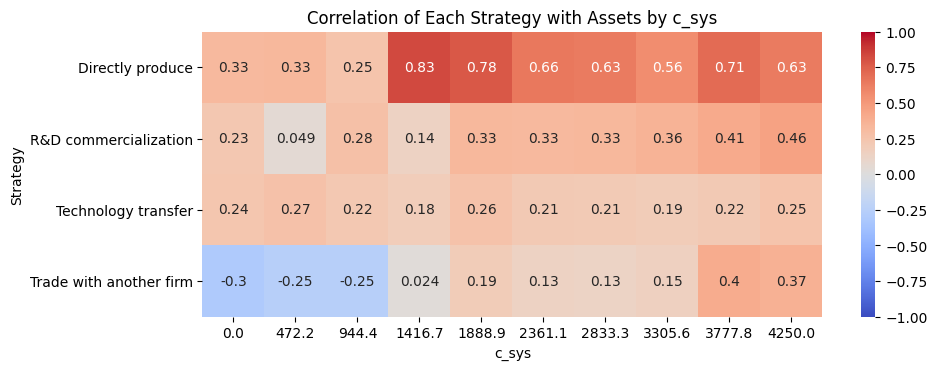

In [50]:

# 创建一个透视表来展示不同策略与资产的相关性
corr_pivot = results_df.pivot('strategy', 'c_sys', 'correlation')

# 转换为数值类型，并处理缺失值
corr_pivot = corr_pivot.apply(pd.to_numeric, errors='coerce').fillna(0)

# 绘制热力图
plt.figure(figsize=(10, 3.7))
sns.heatmap(corr_pivot, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation of Each Strategy with Assets by c_sys')
plt.xlabel('c_sys')
plt.ylabel('Strategy')
plt.show()


Regression coef of strategies in each c_sys

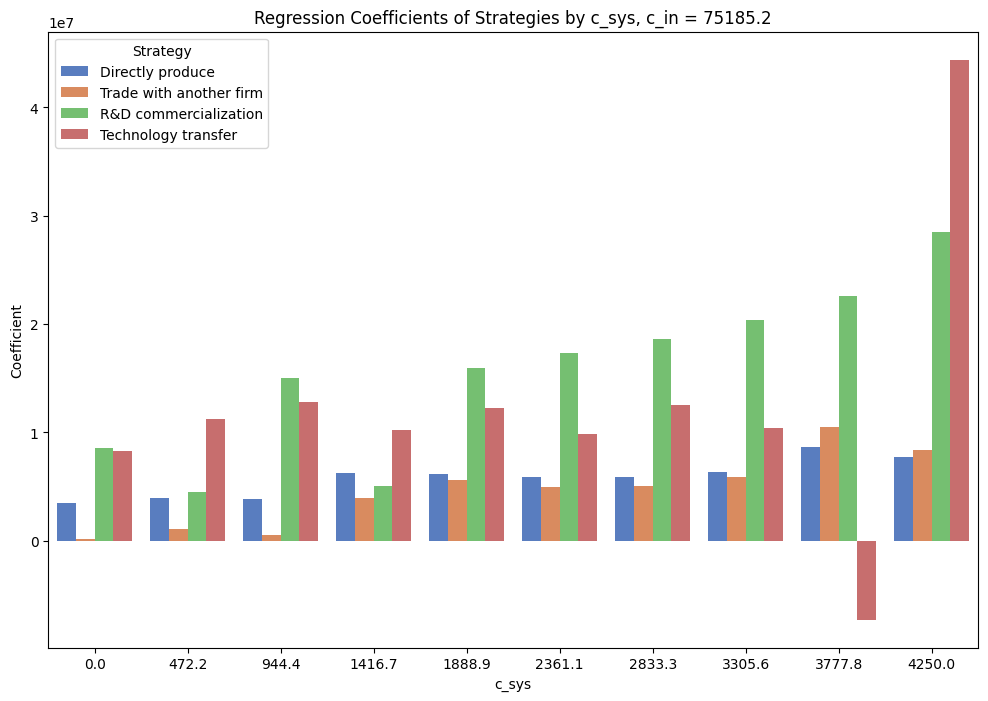

In [51]:
# 以c_sys为x轴，策略为hue，回归系数为y轴，绘制条形图
colors = sns.color_palette("muted")
plt.figure(figsize=(12, 8))
sns.barplot(x='c_sys', y='coefficient', hue='strategy', data=results_df, palette=colors)
plt.title('Regression Coefficients of Strategies by c_sys, c_in = 75185.2')
plt.xlabel('c_sys')
plt.ylabel('Coefficient')
plt.legend(title='Strategy')
plt.show()


/Users/ljm/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


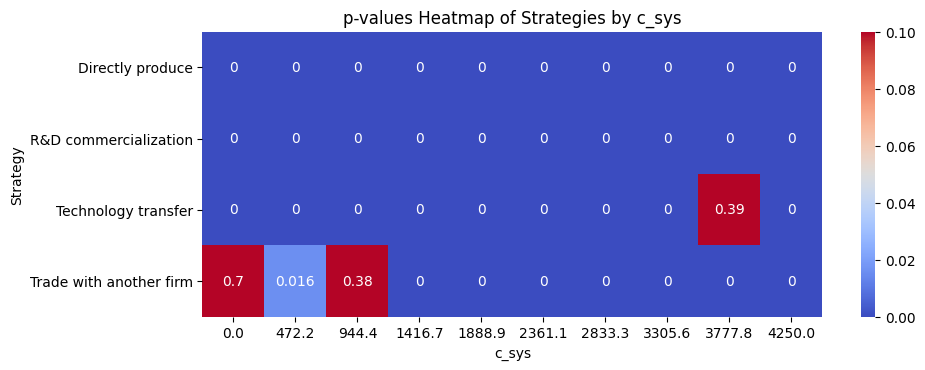

In [52]:
corr_pivot = results_df.pivot('strategy', 'c_sys', 'p_value')
corr_pivot = corr_pivot.apply(pd.to_numeric, errors='coerce').fillna(0)

plt.figure(figsize=(10, 3.7))
sns.heatmap(corr_pivot, annot=True, cmap="coolwarm", vmin=0, vmax=0.1)
plt.title('p-values Heatmap of Strategies by c_sys')
plt.xlabel('c_sys')
plt.ylabel('Strategy')
plt.show()


In [54]:
results_df.columns

Index(['c_sys', 'strategy', 'correlation', 'coefficient', 'p_value',
       'r_squared', 'adj_r_squared'],
      dtype='object')

In [60]:
sum_df_strategy = merged_df.groupby(['run', 'c_sys']).sum().reset_index()

In [57]:
sum_df_strategy.columns

Index(['run', 'AgentID', 'c_sys', 'No production', 'Directly produce',
       'Trade with another firm', 'R&D commercialization',
       'Technology transfer', 'Assets', 'PositionX', 'PositionY', 'Position',
       'AccInnocost', 'Supply community Numbers', 'Inno_cost_percent'],
      dtype='object')

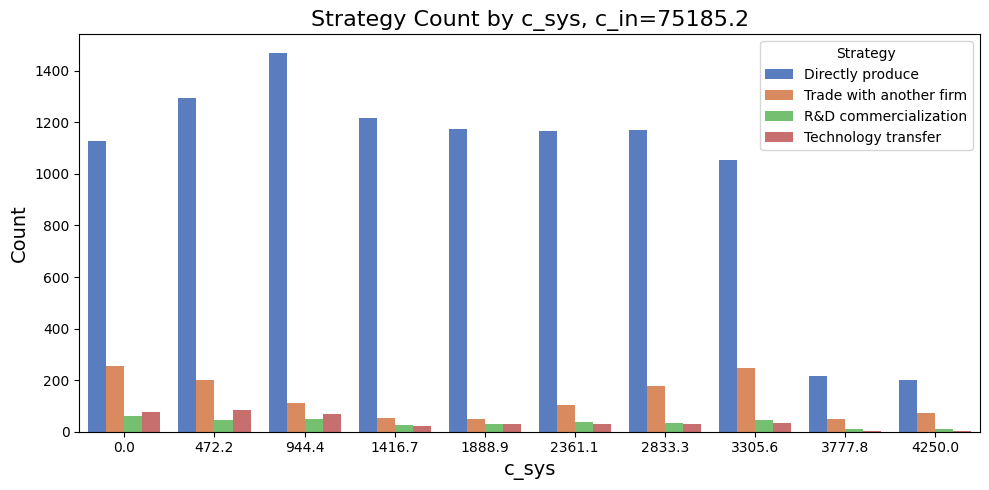

In [62]:
# 将策略列放入一个列表
sum_df_strategy['c_sys'] = round(sum_df_strategy['c_sys'], 1)
strategies = ['Directly produce',
       'Trade with another firm', 'R&D commercialization',
       'Technology transfer']

colors = sns.color_palette("muted")

# 将数据从宽格式转换为长格式
df_long = sum_df_strategy.melt(id_vars=['c_sys'], value_vars=strategies, var_name='strategy', value_name='count')

# 绘制柱状图
plt.figure(figsize=(10, 5))
sns.barplot(data=df_long, x='c_sys', y='count', hue='strategy', palette=colors, ci=None)

# 添加标题和标签
plt.title('Strategy Count by c_sys, c_in=75185.2', fontsize = 16)
plt.xlabel('c_sys', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.legend(title='Strategy')
#plt.xticks(rotation=45)  # 如果x轴刻度重叠可以旋转一下

# 显示图表
plt.tight_layout()
plt.show()

In [40]:
max_asset_list = []
for c_sys in cb_c_sys_test_agent_grouped['c_sys'].unique():
        max_asset = max(cb_c_sys_test_agent_grouped[(cb_c_sys_test_agent_grouped['c_sys'] == c_sys) & (cb_c_sys_test_agent_grouped['Step'] == 30)]['Assets'])
        agentid = cb_c_sys_test_agent_grouped[(cb_c_sys_test_agent_grouped['c_sys'] == c_sys) & (cb_c_sys_test_agent_grouped['Step'] == 30) & (cb_c_sys_test_agent_grouped['Assets'] == max_asset)]['AgentID'].values[0]
        max_asset_list.append(agentid)
max_asset_list

[12, 16, 43, 7, 30, 49, 16, 41, 84, 22]

In [39]:
import statsmodels.api as sm
from statsmodels.tools import add_constant

In [41]:
cb_c_sys_test_agent.columns

Index(['Step', 'AgentID', 'Assets', 'AccInnocost', 'C_i', 'profit_pi',
       'R_tr_i', 'P_t_i', 'C_in', 'C_op', 'C_p', 'P_t_c', 'C_sys', 'C_om',
       'R_tr_c', 'R_rd', 'percent_of_PV_power', 'Electricity demand',
       'PV power (kWh)', 'Community PV installed', 'Community p_e',
       'Residences', 'PV_Source', 'Source_ID', 'Inno_step', 'K_capital',
       'Global max quality', 'max Inno quality', 'min Inno quality',
       'max Product quality', 'min Product quality', 'Lab product number',
       'Prod line product number', 'Production cost (c_p)', 'Product price',
       'Tech_tr_price', 'Inno prod number', 'Firm_type', 'Firm_type_change',
       'Inno_cost_percent', 'PositionX', 'PositionY', 'Position',
       'Electricity price', 'Supply community ID', 'Supply community Numbers',
       'Supply community p_e', 'Inno pi', 'Step income', 'Step profit', 'run',
       'c_sys'],
      dtype='object')

In [43]:
grouped_asset_std = cb_c_sys_test_agent.groupby('AgentID')['Assets'].var()
grouped_asset_std[[12, 16, 43, 7, 30, 49, 16, 41, 84, 22]]

AgentID
12    2.472136e+15
16    2.314690e+15
43    3.216589e+15
7     2.257897e+15
30    2.792042e+15
49    2.216896e+15
16    2.314690e+15
41    3.157406e+15
84    2.937416e+15
22    2.376436e+15
Name: Assets, dtype: float64

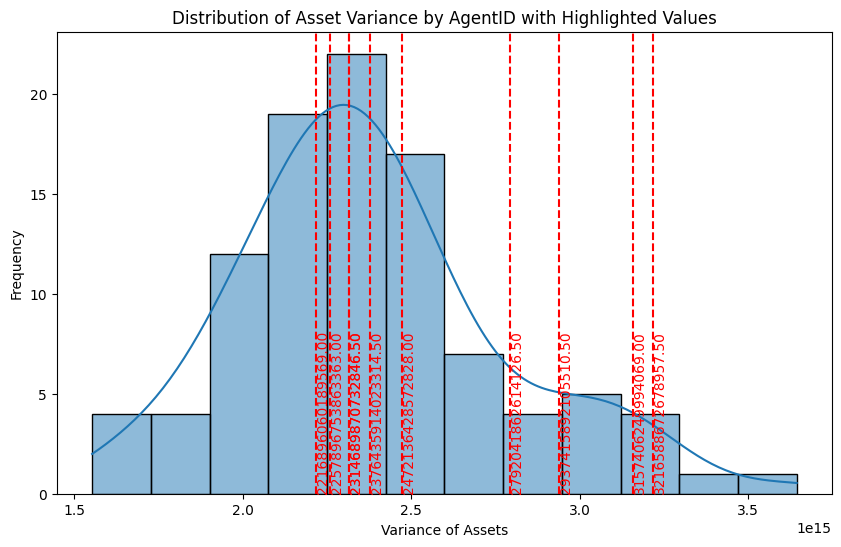

In [47]:

highlight_values = grouped_asset_std[[12, 16, 43, 7, 30, 49, 16, 41, 84, 22]]

# 绘制方差的分布直方图
plt.figure(figsize=(10, 6))
sns.histplot(grouped_asset_std, kde=True)  # 绘制直方图和核密度估计曲线

# 在图中标记指定的数据点
for value in highlight_values:
    plt.axvline(x=value, color='red', linestyle='--', linewidth=1.5)
    plt.text(value, 0, f'{value:.2f}', color='red', rotation=90, verticalalignment='bottom')

# 设置图表标题和轴标签
plt.title('Distribution of Asset Variance by AgentID with Highlighted Values')
plt.xlabel('Variance of Assets')
plt.ylabel('Frequency')

# 显示图表
plt.show()

In [37]:
subdata = cb_c_sys_test_agent.copy()

dummy_strat = pd.get_dummies(subdata['PV_Source'], drop_first=True)
X = add_constant(pd.concat([subdata[['Inno pi', 'c_sys']], dummy_strat], axis=1)).dropna()

y = subdata['Assets'].dropna()

# 进行线性回归
model = sm.OLS(y, X).fit()

# 打印回归分析结果
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 Assets   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     6218.
Date:                Sun, 18 Aug 2024   Prob (F-statistic):               0.00
Time:                        18:39:51   Log-Likelihood:            -1.1399e+07
No. Observations:              596882   AIC:                         2.280e+07
Df Residuals:                  596876   BIC:                         2.280e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        3.25e+07    1.4e+05    232.676      0.0

In [21]:
cb_c_sys_test_agent_grouped[cb_c_sys_test_agent_grouped['AgentID'].isin(max_asset_list)][['Assets', "PV_Source", 'Prod line product number', 'max Product quality', 'Lab product number', 'max Inno quality', 'Inno_cost_percent', 'Step', 'PositionX', 'PositionY', 'c_sys']]

,Assets,PV_Source,Prod line product number,max Product quality,Lab product number,max Inno quality,Inno_cost_percent,Step,PositionX,PositionY,c_sys
7,8.239410e+05,0.700000,0.950000,1.0,0.100000,1.000368,0.158339,1,3.350000,5.100000,0.0
12,9.416235e+05,0.700000,1.000000,1.0,0.400000,1.001864,0.123007,1,4.650000,5.650000,0.0
16,6.712174e+05,0.800000,1.250000,1.0,0.250000,1.000300,0.160274,1,4.000000,4.100000,0.0
22,1.315012e+06,0.600000,0.900000,1.0,0.300000,1.001269,0.156438,1,4.300000,4.400000,0.0
30,7.892624e+05,0.750000,1.200000,1.0,0.150000,1.000838,0.131857,1,3.900000,4.050000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
50860,5.736771e+06,0.052632,0.947368,1.0,0.157895,1.104151,0.125532,30,4.473684,5.263158,4250.0
50871,1.047345e+07,0.052632,1.052632,1.0,0.210526,1.061362,0.145510,30,3.157895,5.000000,4250.0
50873,7.992954e+07,0.000000,0.736842,1.0,0.105263,1.138037,0.119337,30,3.368421,4.789474,4250.0
50879,3.929603e+07,0.052632,0.894737,1.0,0.263158,1.149949,0.137333,30,4.736842,4.368421,4250.0


##### The relationship between the final asset and innovation perference.

In [142]:
cb_c_sys_test_agent.columns

Index(['Step', 'AgentID', 'Assets', 'AccInnocost', 'C_i', 'profit_pi',
       'R_tr_i', 'P_t_i', 'C_in', 'C_op', 'C_p', 'P_t_c', 'C_sys', 'C_om',
       'R_tr_c', 'R_rd', 'percent_of_PV_power', 'Electricity demand',
       'PV power (kWh)', 'Community PV installed', 'Community p_e',
       'Residences', 'PV_Source', 'Source_ID', 'Inno_step', 'K_capital',
       'Global max quality', 'max Inno quality', 'min Inno quality',
       'max Product quality', 'min Product quality', 'Lab product number',
       'Prod line product number', 'Production cost (c_p)', 'Product price',
       'Tech_tr_price', 'Inno prod number', 'Firm_type', 'Firm_type_change',
       'Inno_cost_percent', 'PositionX', 'PositionY', 'Position',
       'Electricity price', 'Supply community ID', 'Supply community Numbers',
       'Supply community p_e', 'Inno pi', 'Step income', 'Step profit', 'run',
       'c_sys'],
      dtype='object')

In [150]:
step_30_data = cb_c_sys_test_agent[cb_c_sys_test_agent['Step'] == 30]
#X = step_30_data[['AccInnocost', 'Inno_cost_percent']].dropna()
#X = step_30_data['Inno_cost_percent'].dropna()
X = step_30_data[['Supply community Numbers', 'Position']].dropna()
X = sm.add_constant(X)
y = step_30_data['Assets'].dropna()

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Assets   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                 1.166e+04
Date:                Mon, 19 Aug 2024   Prob (F-statistic):               0.00
Time:                        21:27:49   Log-Likelihood:            -3.7784e+05
No. Observations:               19579   AIC:                         7.557e+05
Df Residuals:                   19576   BIC:                         7.557e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

##### Relationship between asset and position

Text(0.5, 1.0, 'The relationship between final asset and region, step=30')

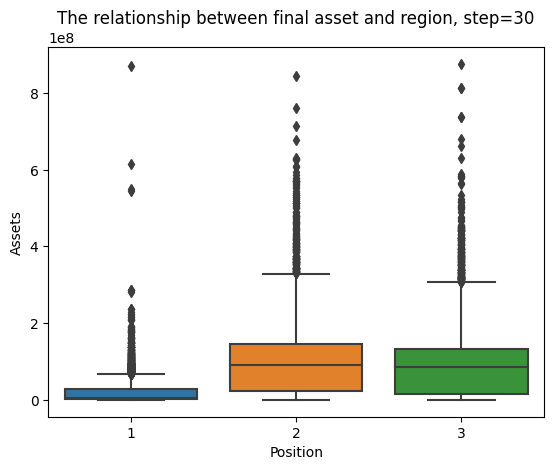

In [185]:
sns.boxplot(x = 'Position', y = 'Assets', data = step_30_data)
plt.title('The relationship between final asset and region, step=30')

In [183]:
dummy_position = pd.get_dummies(merged_df['Position'], drop_first=True)
dummy_position.rename({2:"2nd_area", 3:"3rd_area"}, axis=1, inplace=True)


X = sm.add_constant(dummy_position)
y = merged_df['Assets']

model = sm.OLS(y, X).fit()

# 打印回归分析结果
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Assets   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     1716.
Date:                Tue, 20 Aug 2024   Prob (F-statistic):               0.00
Time:                        00:45:34   Log-Likelihood:            -3.8394e+05
No. Observations:               19579   AIC:                         7.679e+05
Df Residuals:                   19576   BIC:                         7.679e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.089e+07   1.14e+06     18.318      0.0

In [188]:
asset_by_region

,Step,Position,Assets
0,1,1,2.080935e+06
1,1,2,8.853441e+05
2,1,3,1.084649e+06
3,2,1,2.027996e+06
4,2,2,7.860305e+05
...,...,...,...
85,29,2,9.888834e+07
86,29,3,8.573274e+07
87,30,1,2.089494e+07
88,30,2,1.061391e+08


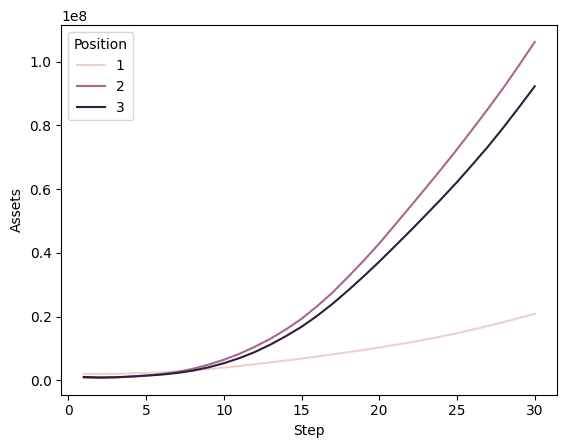

In [189]:
asset_by_region = cb_c_sys_test_agent.groupby(["Step", 'Position'])['Assets'].mean().reset_index()
sns.lineplot(x = 'Step', y = 'Assets', data = asset_by_region, hue = 'Position')
plt.show()

##### The relationship between position and invested project number

Relationship between invested project number and position

In [163]:
# 定义三个区域
# 左上区域的条件
left_upper = (merged_df['PositionX'] < 4) & (merged_df['PositionY'] < 4)

# 左下区域的条件
left_lower = (merged_df['PositionX'] < 4) & (merged_df['PositionY'] > 5)

# 右侧区域的条件
right_side = (merged_df['PositionX'] > 5)

sub_position = merged_df[left_upper | left_lower | right_side]
dummy_position = pd.get_dummies(sub_position['Position'], drop_first=True)
X = sm.add_constant(dummy_position)
y = merged_df[left_upper | left_lower | right_side]['Supply community Numbers']

model = sm.OLS(y, X).fit()

# 打印回归分析结果
print(model.summary())

                               OLS Regression Results                               
Dep. Variable:     Supply community Numbers   R-squared:                       0.209
Model:                                  OLS   Adj. R-squared:                  0.208
Method:                       Least Squares   F-statistic:                     1865.
Date:                      Mon, 19 Aug 2024   Prob (F-statistic):               0.00
Time:                              23:36:36   Log-Likelihood:                -51320.
No. Observations:                     14155   AIC:                         1.026e+05
Df Residuals:                         14152   BIC:                         1.027e+05
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

The relationship between strategies and position, accinnocost, and project number

In [179]:
dummy_position = pd.get_dummies(merged_df['Position'], drop_first=True)
dummy_position_df = pd.concat([merged_df, dummy_position], axis=1)
dummy_position_df.rename({2:"2nd_area", 3:"3rd_area"}, axis=1, inplace=True)

# 假设 df 是您的数据框
for strategy in ["CAP_d", "CAP_t", "CAP_rd", "CAP_tr"]:
    X = dummy_position_df[["2nd_area", "3rd_area", 'AccInnocost']]
    y = merged_df[strategy]
    X = sm.add_constant(X)  # 添加常数项
    model = sm.OLS(y, X).fit()
    print(f"策略 {strategy} 的回归结果：")
    print(model.summary())

策略 CAP_d 的回归结果：
                            OLS Regression Results                            
Dep. Variable:                  CAP_d   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     1097.
Date:                Mon, 19 Aug 2024   Prob (F-statistic):               0.00
Time:                        23:55:33   Log-Likelihood:                -70021.
No. Observations:               19579   AIC:                         1.400e+05
Df Residuals:                   19575   BIC:                         1.401e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.5688      0.126 

##### Plots for income and profit variation

Income

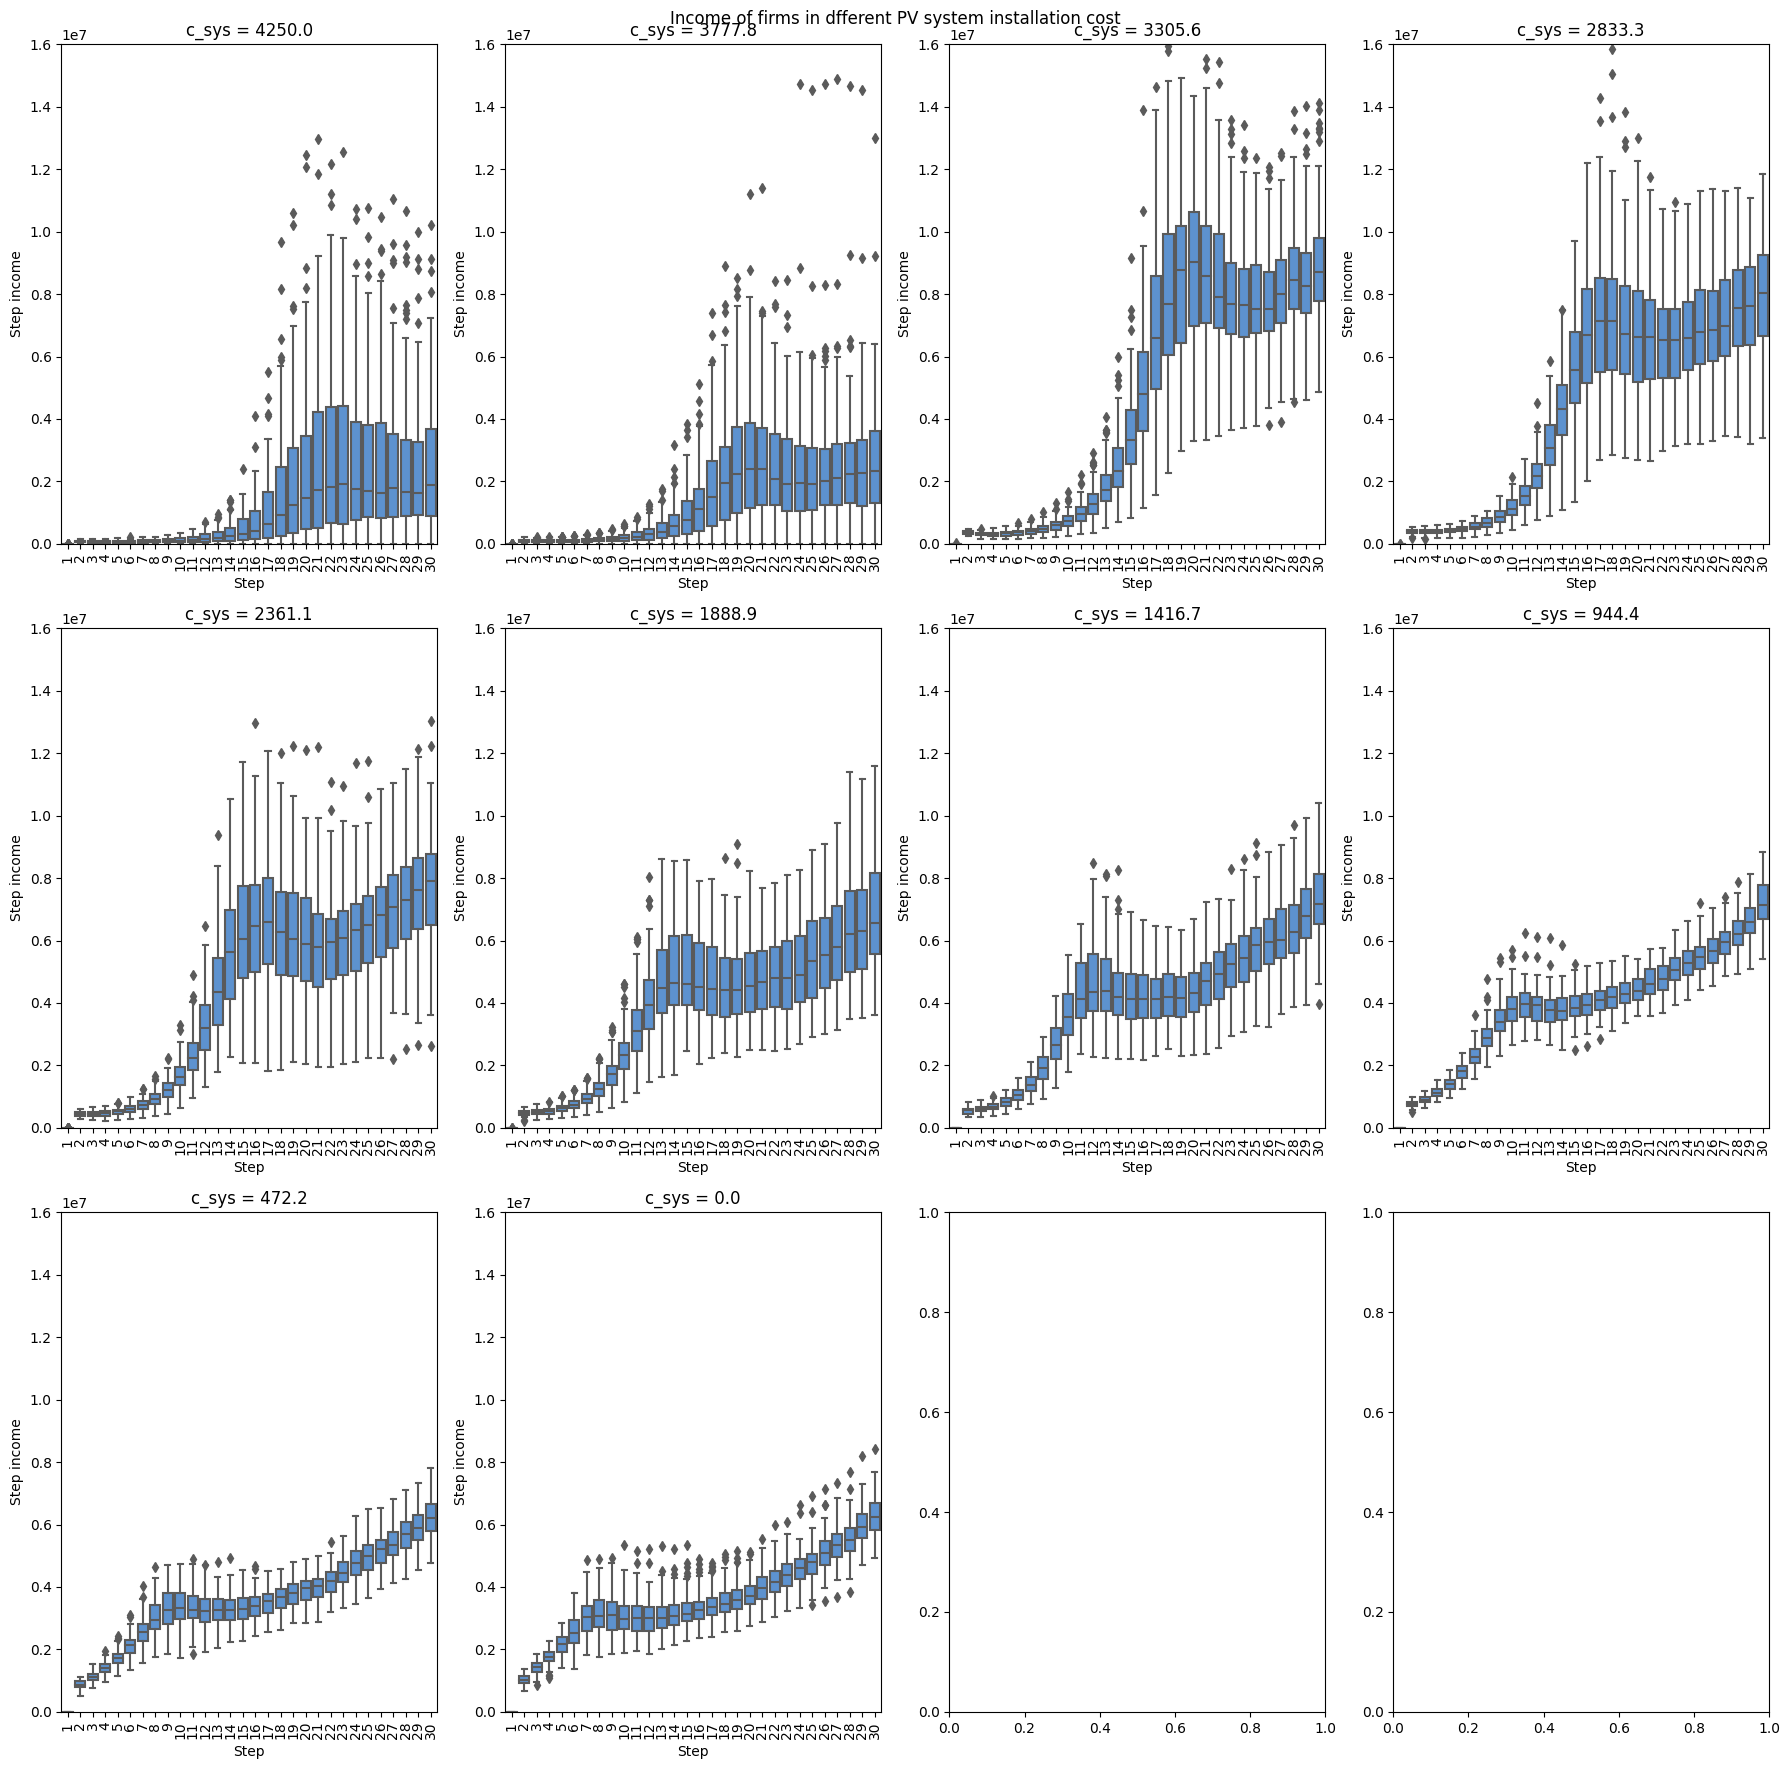

In [358]:
cb_c_sys_test_agent = pd.concat(c_sys_test_agent)
cb_c_sys_test_agent = cb_c_sys_test_agent.reset_index().rename(columns={'index':'Step'})

cb_c_sys_test_agent_grouped = cb_c_sys_test_agent.groupby(['c_sys', 'Step', 'AgentID']).mean().reset_index()
# Plotting
# Define a color palette
colors = "#4a90e2"

fig, axes = plt.subplots(3, 4, figsize=(18, 18))
axes = axes.flatten()
# Plotting for each `c_sys` separately with improved aesthetics
for c_sys_value, ax in zip(cb_c_sys_test_agent['c_sys'].unique()[::-1], axes):
    
    # Subset the data for the current `c_in_value`
    subset = cb_c_sys_test_agent_grouped[cb_c_sys_test_agent_grouped['c_sys'] == c_sys_value]
    
    # Plot the scatter plot for Asset over time (Step)
    sns.boxplot(x = 'Step', y = 'Step income', data = subset, ax=ax, color = colors)
    
    #ax.set_ylim(0, 9000000)
    
    # Set the title and labels
    ax.set_title(f'c_sys = {round(c_sys_value, 1)}')
    ax.set_xlabel('Step')
    ax.set_ylabel('Step income')

    ax.xaxis.set_tick_params(labelrotation=90)
    
    # Optionally set consistent y-axis limits
    ax.set_ylim(0, 16000000)  # Adjust according to data range

fig.suptitle('Income of firms in dfferent PV system installation cost')
# Adjust the layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()

Profit

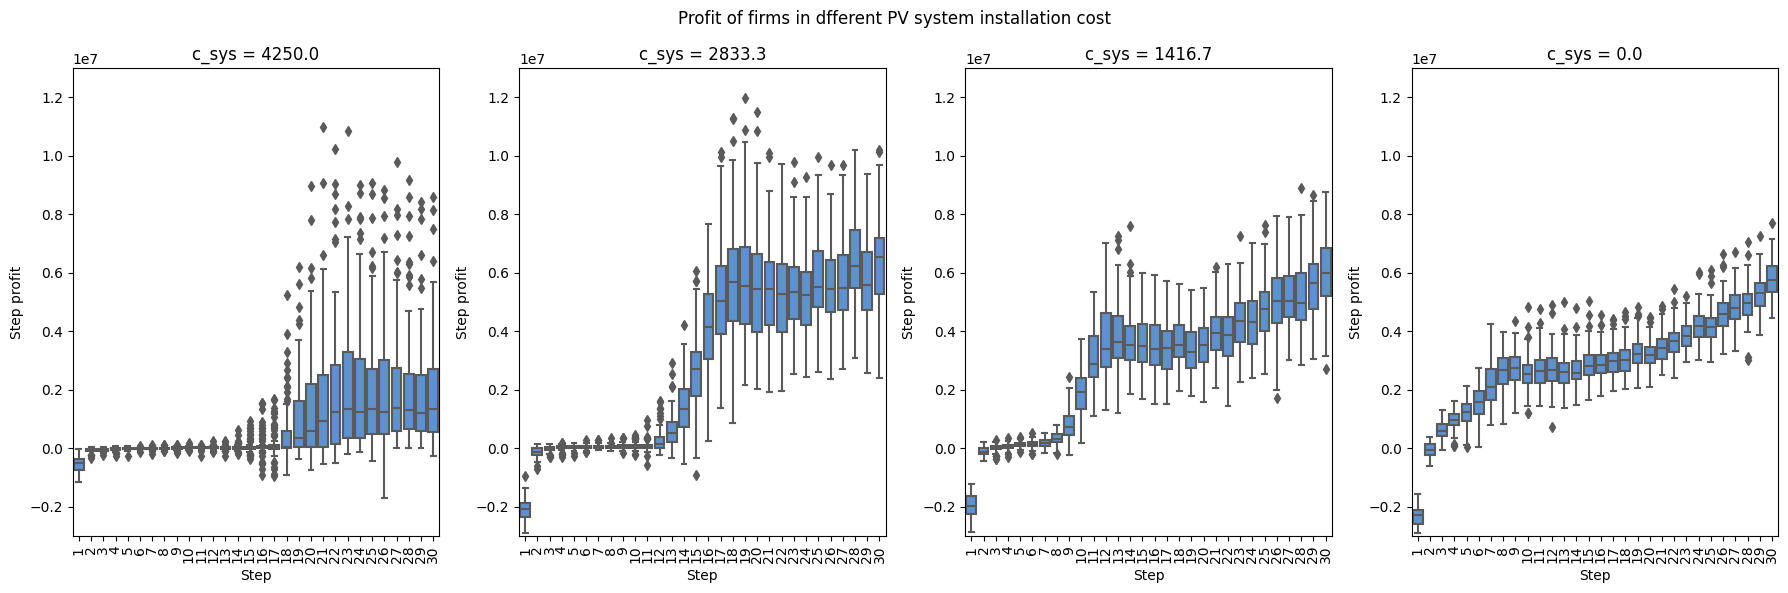

In [367]:
cb_c_sys_test_agent = pd.concat(c_sys_test_agent)
cb_c_sys_test_agent = cb_c_sys_test_agent.reset_index().rename(columns={'index':'Step'})

cb_c_sys_test_agent_grouped = cb_c_sys_test_agent.groupby(['c_sys', 'Step', 'AgentID']).mean().reset_index()
# Plotting
# Define a color palette
colors = "#4a90e2"

fig, axes = plt.subplots(1, 4, figsize=(18, 6))
axes = axes.flatten()
# Plotting for each `c_sys` separately with improved aesthetics
for c_sys_value, ax in zip(cb_c_sys_test_agent['c_sys'].unique()[[9, 6, 3, 0]], axes):
    
    # Subset the data for the current `c_in_value`
    subset = cb_c_sys_test_agent_grouped[cb_c_sys_test_agent_grouped['c_sys'] == c_sys_value]
    
    # Plot the scatter plot for Asset over time (Step)
    sns.boxplot(x = 'Step', y = 'Step profit', data = subset, ax=ax, color = colors)
    
    #ax.set_ylim(0, 310000000)
    
    # Set the title and labels
    ax.set_title(f'c_sys = {round(c_sys_value, 1)}')
    ax.set_xlabel('Step')
    ax.set_ylabel('Step profit')

    ax.xaxis.set_tick_params(labelrotation=90)
    
    # Optionally set consistent y-axis limits
    ax.set_ylim(-3000000, 13000000)  # Adjust according to data range
    #ax.set_ylim(-3000000, 30000000)  # Adjust according to data range

fig.suptitle('Profit of firms in dfferent PV system installation cost')
# Adjust the layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()

Innovation profit

In [268]:
xticks

[0, 5, 10, 15, 20, 25, 30]

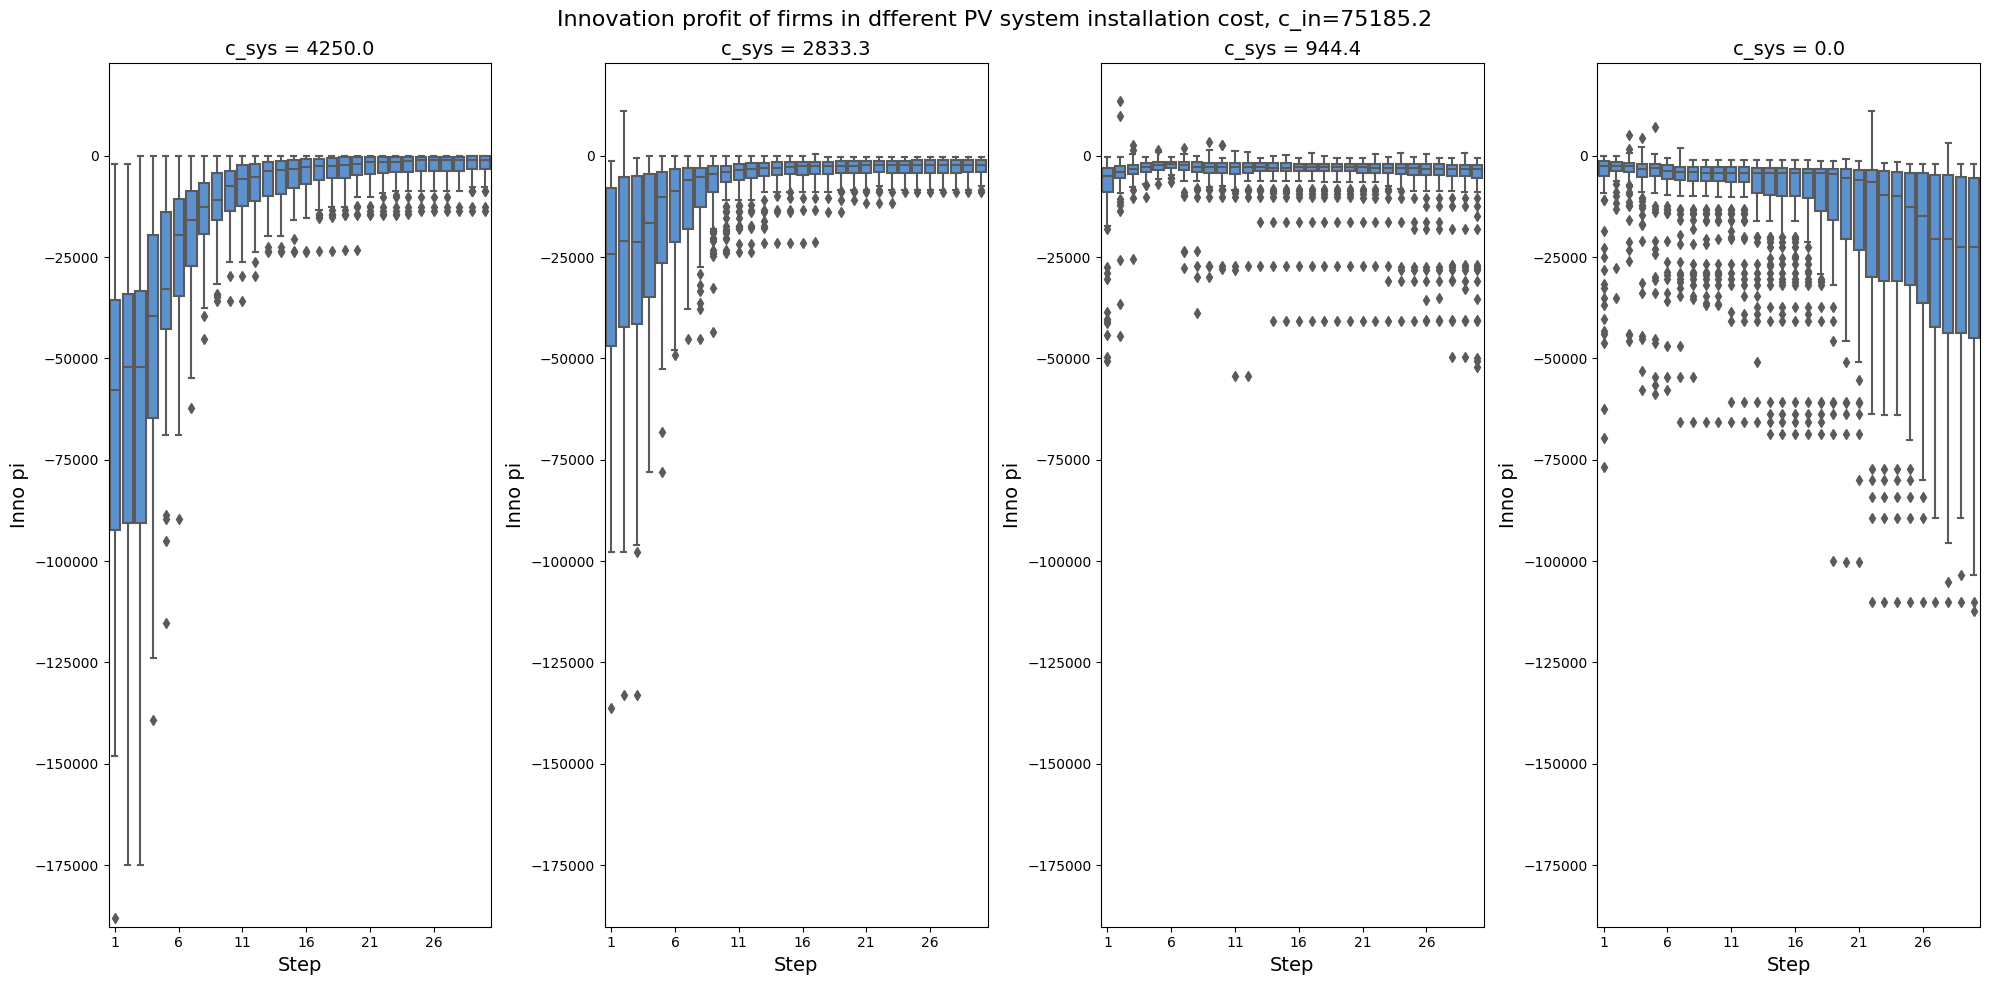

In [269]:
cb_c_sys_test_agent = pd.concat(c_sys_test_agent)
cb_c_sys_test_agent = cb_c_sys_test_agent.reset_index().rename(columns={'index':'Step'})

cb_c_sys_test_agent_grouped = cb_c_sys_test_agent.groupby(['c_sys', 'Step', 'AgentID']).mean().reset_index()

y_min = min(cb_c_sys_test_agent_grouped['Inno pi'])
y_max = max(cb_c_sys_test_agent_grouped['Inno pi'])
xticks = list(range(0, int(cb_c_in_test_agent_sub['Step'].max()), 5)) 
# Plotting
# Define a color palette
colors = "#4a90e2"

fig, axes = plt.subplots(1, 4, figsize=(20, 10))
axes = axes.flatten()
# Plotting for each `c_sys` separately with improved aesthetics
for c_sys_value, ax in zip(cb_c_sys_test_agent_grouped['c_sys'].unique()[[9, 6, 2, 0]], axes):
    
    # Subset the data for the current `c_in_value`
    #subset = cb_c_sys_test_agent_grouped[cb_c_sys_test_agent_grouped['c_sys'] == c_sys_value]
    subset = cb_c_sys_test_agent_grouped[cb_c_sys_test_agent_grouped['c_sys'] == c_sys_value]
    
    # Plot the scatter plot for Asset over time (Step)
    sns.boxplot(x = 'Step', y = 'Inno pi', data = subset, ax=ax, color = colors)
    
    #ax.set_ylim(0, 310000000)
    
    # Set the title and labels
    ax.set_title(f'c_sys = {round(c_sys_value, 1)}', fontsize=14)
    ax.set_xlabel('Step', fontsize=14)
    ax.set_ylabel('Inno pi', fontsize=14)

    #ax.xaxis.set_tick_params(labelrotation=90)
    ax.set_xticks(xticks)
    # Optionally set consistent y-axis limits
    #ax.set_ylim(-5000000, 10000000)  # Adjust according to data range
    #ax.set_ylim(-25000, 0)  # Adjust according to data range
    ax.set_ylim(y_min, y_max)  # Adjust according to data range

fig.suptitle('Innovation profit of firms in dfferent PV system installation cost, c_in=75185.2', fontsize=16)

# Adjust the layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()

In [229]:
cb_c_sys_test_agent.columns

Index(['Step', 'AgentID', 'Assets', 'AccInnocost', 'C_i', 'profit_pi',
       'R_tr_i', 'P_t_i', 'C_in', 'C_op', 'C_p', 'P_t_c', 'C_sys', 'C_om',
       'R_tr_c', 'R_rd', 'percent_of_PV_power', 'Electricity demand',
       'PV power (kWh)', 'Community PV installed', 'Community p_e',
       'Residences', 'PV_Source', 'Source_ID', 'Inno_step', 'K_capital',
       'Global max quality', 'max Inno quality', 'min Inno quality',
       'max Product quality', 'min Product quality', 'Lab product number',
       'Prod line product number', 'Production cost (c_p)', 'Product price',
       'Tech_tr_price', 'Inno prod number', 'Firm_type', 'Firm_type_change',
       'Inno_cost_percent', 'PositionX', 'PositionY', 'Position',
       'Electricity price', 'Supply community ID', 'Supply community Numbers',
       'Supply community p_e', 'Inno pi', 'Step income', 'Step profit', 'run',
       'c_sys'],
      dtype='object')

max production line product quality

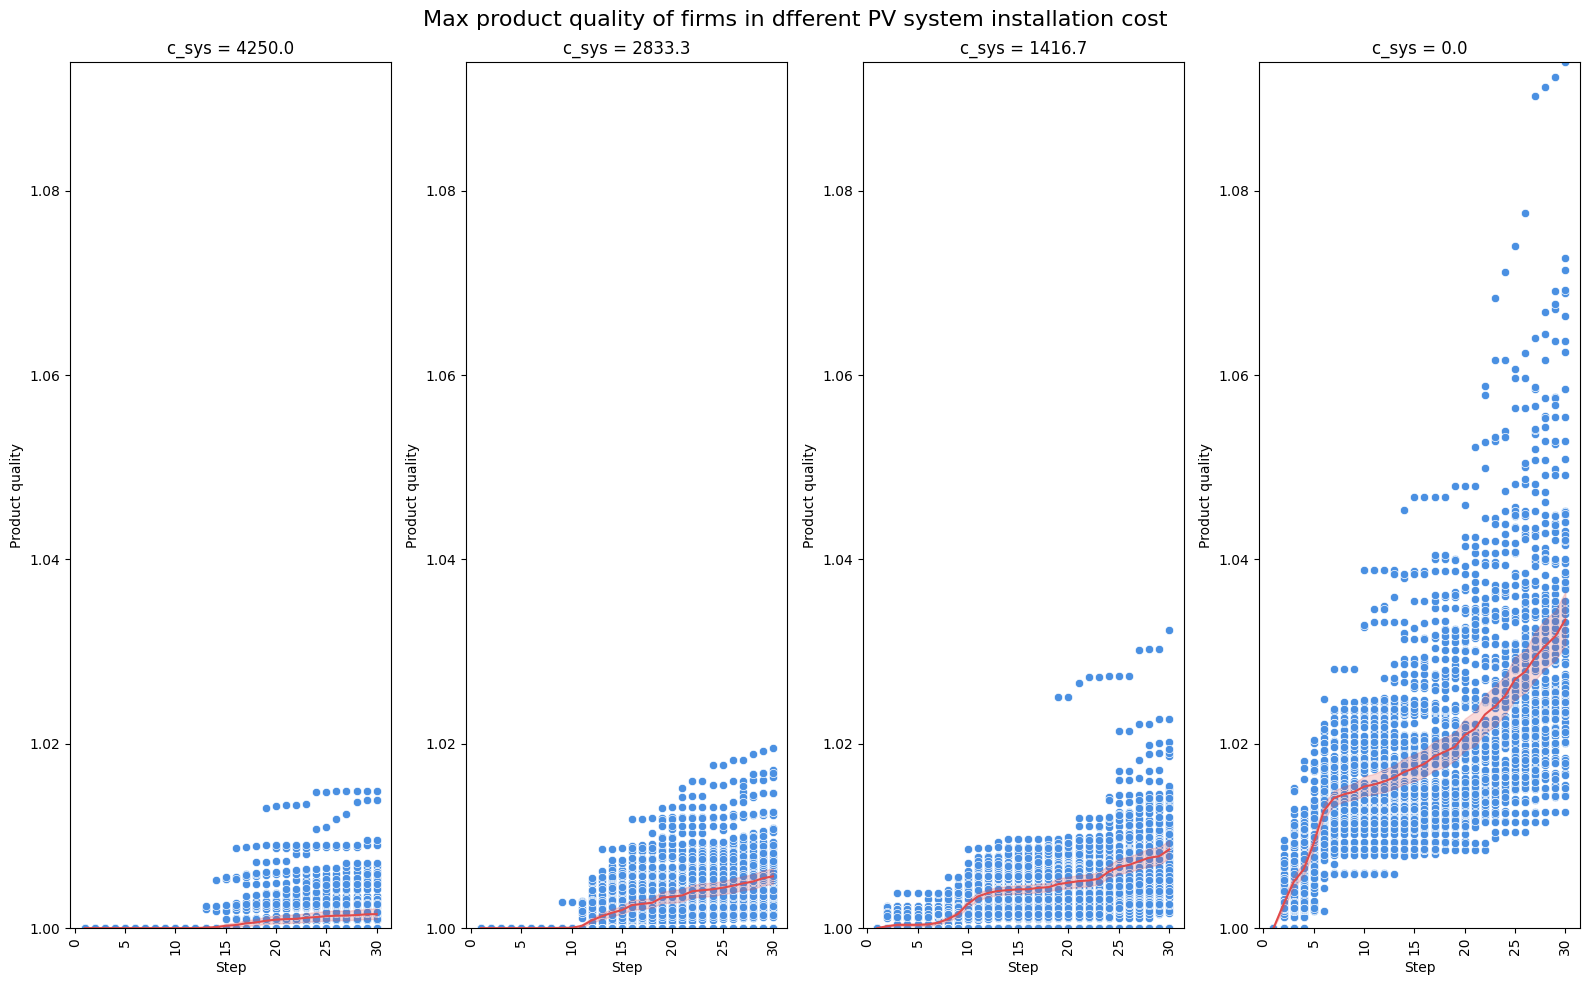

In [256]:
cb_c_sys_test_agent = pd.concat(c_sys_test_agent)
cb_c_sys_test_agent = cb_c_sys_test_agent.reset_index().rename(columns={'index':'Step'})

cb_c_sys_test_agent_grouped = cb_c_sys_test_agent.groupby(['c_sys', 'Step', 'AgentID']).mean().reset_index()

y_min = min(cb_c_sys_test_agent_grouped['max Product quality'])
y_max = max(cb_c_sys_test_agent_grouped['max Product quality'])

# Plotting
# Define a color palette
colors = ["#4a90e2", "#e24a4a"] 

fig, axes = plt.subplots(1, 4, figsize=(16, 10))
axes = axes.flatten()
# Plotting for each `c_sys` separately with improved aesthetics
for c_sys_value, ax in zip(cb_c_sys_test_agent['c_sys'].unique()[[9, 6, 3, 0]], axes):
    
    # Subset the data for the current `c_in_value`
    subset = cb_c_sys_test_agent_grouped[cb_c_sys_test_agent_grouped['c_sys'] == c_sys_value]
    
    # Plot the scatter plot for Asset over time (Step)
    sns.scatterplot(x = 'Step', y = 'max Product quality', data = subset, ax=ax, color = colors[0])
    sns.lineplot(x = 'Step', y = 'max Product quality', data = subset, ax=ax, color = colors[1])
    #ax.set_ylim(0, 310000000)
    #sns.lineplot(x='Step', y='Global max quality', data=subset, ax=ax, color=colors[1], label='Global Max Quality')
    
    # Set the title and labels
    ax.set_title(f'c_sys = {round(c_sys_value, 1)}')
    ax.set_xlabel('Step')
    ax.set_ylabel('Product quality')

    ax.xaxis.set_tick_params(labelrotation=90)
    
    # Optionally set consistent y-axis limits
    #ax.set_ylim(-5000000, 10000000)  # Adjust according to data range
    ax.set_ylim(y_min, y_max)  # Adjust according to data range

fig.suptitle('Max product quality of firms in dfferent PV system installation cost', fontsize=16)
# Adjust the layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()

The relationship between income and max product quality

In [207]:
cb_c_sys_test_agent.columns

Index(['Step', 'AgentID', 'Assets', 'AccInnocost', 'C_i', 'profit_pi',
       'R_tr_i', 'P_t_i', 'C_in', 'C_op', 'C_p', 'P_t_c', 'C_sys', 'C_om',
       'R_tr_c', 'R_rd', 'percent_of_PV_power', 'Electricity demand',
       'PV power (kWh)', 'Community PV installed', 'Community p_e',
       'Residences', 'PV_Source', 'Source_ID', 'Inno_step', 'K_capital',
       'Global max quality', 'max Inno quality', 'min Inno quality',
       'max Product quality', 'min Product quality', 'Lab product number',
       'Prod line product number', 'Production cost (c_p)', 'Product price',
       'Tech_tr_price', 'Inno prod number', 'Firm_type', 'Firm_type_change',
       'Inno_cost_percent', 'PositionX', 'PositionY', 'Position',
       'Electricity price', 'Supply community ID', 'Supply community Numbers',
       'Supply community p_e', 'Inno pi', 'Step income', 'Step profit', 'run',
       'c_sys'],
      dtype='object')

In [313]:
cb_c_sys_test_agent

Assets  AccInnocost  C_i  profit_pi  R_tr_i  P_t_i  C_in  \
Step AgentID                                                                   
1    0        2.895693e+06          0.0  0.0        0.0     0.0    0.0   0.0   
     1        3.183631e+06          0.0  0.0        0.0     0.0    0.0   0.0   
     2        1.001394e+05          0.0  0.0        0.0     0.0    0.0   0.0   
     3        7.724610e+04          0.0  0.0        0.0     0.0    0.0   0.0   
     4        5.474885e+03          0.0  0.0        0.0     0.0    0.0   0.0   
...                    ...          ...  ...        ...     ...    ...   ...   
30   165               NaN          NaN  NaN        NaN     NaN    NaN   NaN   
     166               NaN          NaN  NaN        NaN     NaN    NaN   NaN   
     167               NaN          NaN  NaN        NaN     NaN    NaN   NaN   
     168               NaN          NaN  NaN        NaN     NaN    NaN   NaN   
     169               NaN          NaN  NaN        NaN     NaN    NaN   NaN   

              C_op           C_p  P_t_c  ...  Position  Electricity price  \
Step AgentID                             ...                                
1    0         0.0  0.000000e+00    0.0  ...         3                NaN   
     1         0.0  0.000000e+00    0.0  ...         3                NaN   
     2         0.0  2.447436e+06    0.0  ...         3                NaN   
     3         0.0  2.553490e+06    0.0  ...         3                NaN   
     4         0.0  3.194440e+06    0.0  ...         1                NaN   
...            ...           ...    ...  ...       ...                ...   
30   165       NaN           NaN    NaN  ...         3             0.7714   
     166       NaN           NaN    NaN  ...         3             0.7714   
     167       NaN           NaN    NaN  ...         2             0.7713   
     168       NaN           NaN    NaN  ...         3             0.7714   
     169       NaN           NaN    NaN  ...         2             0.7713   

              Supply community ID  Supply community Numbers  \
Step AgentID                                                  
1    0                       -1.0                       0.0   
     1                       -1.0                       0.0   
     2                      131.0                       1.0   
     3                      145.0                       1.0   
     4                      104.0                       1.0   
...                           ...                       ...   
30   165                      NaN                       NaN   
     166                      NaN                       NaN   
     167                      NaN                       NaN   
     168                      NaN                       NaN   
     169                      NaN                       NaN   

              Supply community p_e  Inno pi  Step income   Step profit  run  \
Step AgentID                                                                  
1    0                     -1.0000      0.0          0.0  0.000000e+00    0   
     1                     -1.0000      0.0          0.0  0.000000e+00    0   
     2                      0.7714      0.0          0.0 -2.447436e+06    0   
     3                      0.7714      0.0          0.0 -2.553490e+06    0   
     4                      0.7713      0.0          0.0 -3.194440e+06    0   
...                            ...      ...          ...           ...  ...   
30   165                       NaN      NaN          NaN           NaN   19   
     166                       NaN      NaN          NaN           NaN   19   
     167                       NaN      NaN          NaN           NaN   19   
     168                       NaN      NaN          NaN           NaN   19   
     169                       NaN      NaN          NaN           NaN   19   

               c_sys  
Step AgentID          
1    0           0.0  
     1           0.0  
     2           0.0  
     3        

In [226]:
quality_group = cb_c_sys_test_agent.groupby('c_sys')
for name, group in quality_group:
        df = group[['max Product quality', 'Step income', 'Inno_cost_percent']].dropna()
        print('c_sys = ' + str(round(name, 1)))
        print(df[['Step income', 'max Product quality', "Inno_cost_percent"]].corr())
        y = df['max Product quality']
        X = sm.add_constant(df[['Step income', 'Inno_cost_percent']])
        model = sm.OLS(y, X).fit()
        print(model.summary())
        

c_sys = 0.0
                     Step income  max Product quality  Inno_cost_percent
Step income             1.000000             0.186746           0.051277
max Product quality     0.186746             1.000000           0.105207
Inno_cost_percent       0.051277             0.105207           1.000000
                             OLS Regression Results                            
Dep. Variable:     max Product quality   R-squared:                       0.044
Model:                             OLS   Adj. R-squared:                  0.044
Method:                  Least Squares   F-statistic:                     1230.
Date:                 Tue, 20 Aug 2024   Prob (F-statistic):               0.00
Time:                         04:32:55   Log-Likelihood:             1.0131e+05
No. Observations:                53396   AIC:                        -2.026e+05
Df Residuals:                    53393   BIC:                        -2.026e+05
Df Model:                            2                  

##### Firm type over time

In [181]:
cb_c_sys_test_agent['Firm_type'].value_counts()

3.0    394673
2.0    202537
Name: Firm_type, dtype: int64

<AxesSubplot: xlabel='Step', ylabel='firm_type_number'>

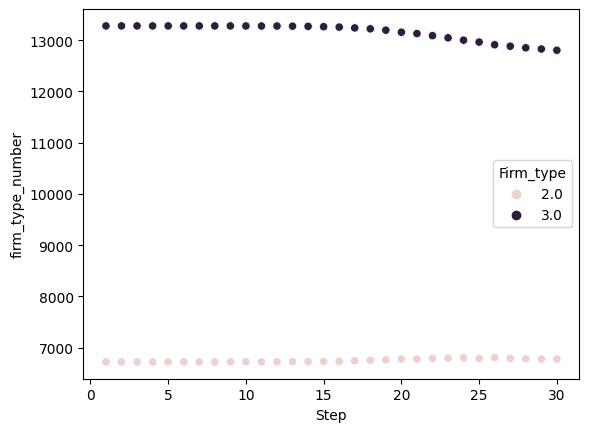

In [287]:
grouped_firm_type = cb_c_sys_test_agent.groupby(['Step'])['Firm_type'].value_counts()
grouped_firm_type_df = pd.DataFrame(grouped_firm_type)
grouped_firm_type_df.rename({'Firm_type':"firm_type_number"}, axis=1, inplace=True)
grouped_firm_type_df.reset_index(inplace=True)
sns.scatterplot(x = 'Step', y = 'firm_type_number', data = grouped_firm_type_df, hue = 'Firm_type', legend=True)

In [ ]:
firm_type_count = cb_c_sys_test_agent.groupby(["Step"])

#### Model validation

/Users/ljm/opt/anaconda3/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


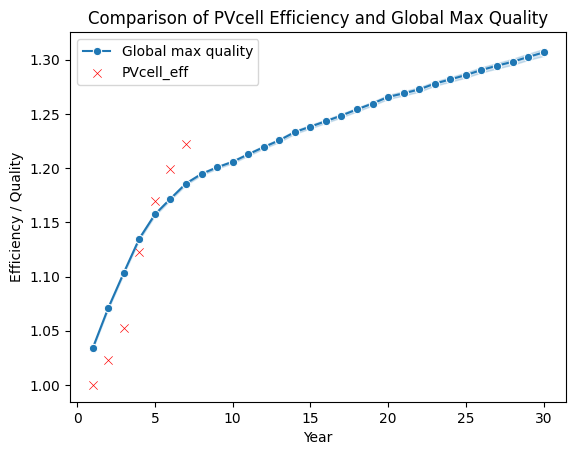

In [312]:
### Innovation validation
PVcell_eff = {
        'Step': [i + 1 for i in range(30)],
        'PVcell_eff' : [i/17.1 for i in [17.1, 17.5, 18, 19.2, 20, 20.5, 20.9]] + [np.nan for i in range(23)]
}
df_PVcell_eff = pd.DataFrame(PVcell_eff)
df_PVcell_eff.set_index('Step', inplace=True)

# Line plot for Global max quality
sns.lineplot(x='Step', y='Global max quality', data=combined_agent_data, label='Global max quality', marker='o')

# Scatter plot for PVcell_eff
sns.scatterplot(x = df_PVcell_eff.index,y = 'PVcell_eff', data = df_PVcell_eff, color='red', label='PVcell_eff', marker='x')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Efficiency / Quality')
plt.title('Comparison of PVcell Efficiency and Global Max Quality')
plt.legend()

# Show plot
plt.show()

In [233]:
combined_model_data

,diffusion rate,PV_capacity,Total_techtr,Global max quality,Global mean quality,Firm_numbers,Up_mid_firms,Up_stream_firms,Mid_stream_firms,Down_stream_firms,...,Type_change_neg3,Type_change_neg0_5,Type_change_1,Type_change_0_5,CAP_d,CAP_t,CAP_rd,CAP_tr,source_0,run
0,0.248796,73386.084286,0,1.0,1.0,100,69,31,0,0,...,0,0,0,100,9,5,0,0,86,0
1,0.250198,76222.773299,0,1.0,1.0,93,64,29,0,0,...,0,0,0,93,0,1,0,0,92,0
2,0.241794,76222.773299,0,1.0,1.0,92,64,28,0,0,...,0,0,0,92,0,0,0,0,92,0
3,0.248357,80794.299556,0,1.0,1.0,92,64,28,0,0,...,0,0,0,92,0,1,0,0,91,0
4,0.240011,80794.299556,0,1.0,1.0,91,64,27,0,0,...,0,0,0,91,0,0,0,0,91,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,0.187171,127586.929947,0,1.0,1.0,71,55,16,0,0,...,0,0,0,69,0,0,0,0,71,14
26,0.180772,127586.929947,0,1.0,1.0,70,54,16,0,0,...,0,0,0,69,0,0,0,0,70,14
27,0.174590,127586.929947,0,1.0,1.0,68,54,14,0,0,...,0,0,0,68,0,0,0,0,68,14
28,0.168618,127586.929947,0,1.0,1.0,66,51,15,0,0,...,0,0,0,64,0,0,0,0,66,14


/Users/ljm/opt/anaconda3/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


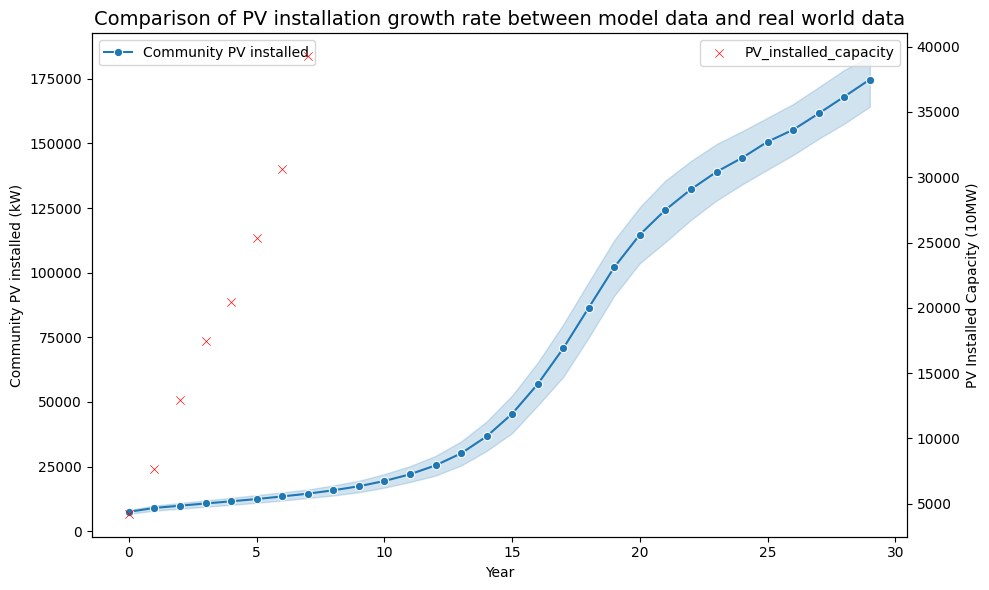

In [311]:
### installation validation
PV_installed_capacity = {
        'Step': [i for i in range(30)],
        'PV_installed_capacity' : [4218, 7631, 12942, 17433, 20418, 25356, 30654, 39268] + [np.nan for i in range(22)]
}
df_PV_installed_capacity = pd.DataFrame(PV_installed_capacity)
df_PV_installed_capacity.set_index('Step', inplace=True)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Line plot for Community PV installed
ax1.set_xlabel('Year')
ax1.set_ylabel('Community PV installed (kW)')
# Line plot for Global max quality
sns.lineplot(x=combined_model_data.index, y='PV_capacity', data=combined_model_data, label='Community PV installed', marker='o')

ax2 = ax1.twinx()
ax2.set_ylabel('PV Installed Capacity (10MW)')
# Scatter plot for PVcell_eff
sns.scatterplot(x = df_PV_installed_capacity.index,y = 'PV_installed_capacity', data = df_PV_installed_capacity, label='PV_installed_capacity', marker='x', color = 'red')

plt.title('Comparison of PV installation growth rate between model data and real world data', fontsize = 14)
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

IndexError: index 24 is out of bounds for axis 0 with size 24

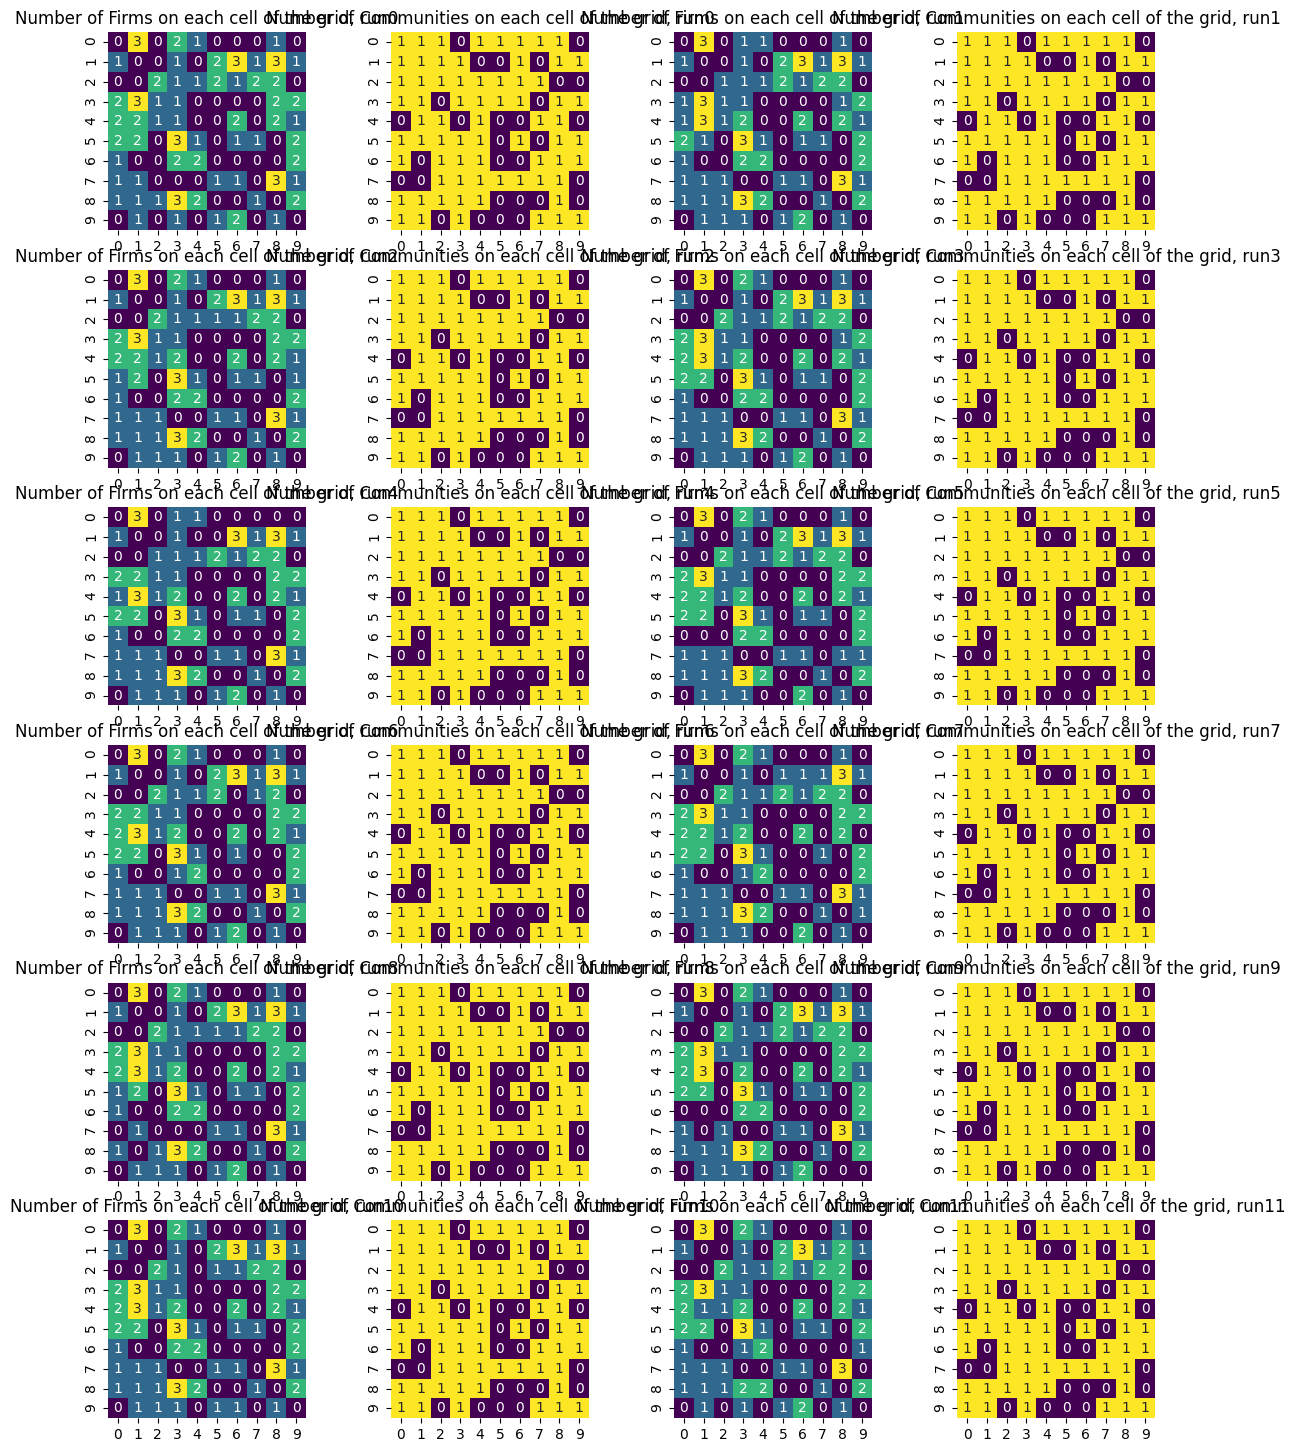

In [64]:
### map
### plot the distribution after modeling
nrows, ncols = 6, 4
fig, axes = plt.subplots(nrows, ncols, figsize = (14, 3 * nrows))
i = 0
for run in Grid_container:

        firm_counts = np.zeros((model.grid.width, model.grid.height))
        community_counts = np.zeros((model.grid.width, model.grid.height))

        for cell_content, (x, y) in run:
                firm_count = sum(isinstance(agent, Firms) for agent in cell_content)
                community_count = sum(isinstance(agent, Communities) for agent in cell_content)
                firm_counts[x][y] = firm_count
                community_counts[x][y] = community_count

        sns.heatmap(firm_counts, cmap="viridis", annot=True, cbar=False, square=True, ax=axes.flatten()[2*i])
        axes.flatten()[2*i].set_title(f"Number of Firms on each cell of the grid, run{i}")

        sns.heatmap(community_counts, cmap="viridis", annot=True, cbar=False, square=True, ax=axes.flatten()[2*i + 1])
        axes.flatten()[2*i + 1].set_title(f"Number of Communities on each cell of the grid, run{i}")

        i += 1

plt.show()

In [56]:
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression

df_fil_pvsource = combined_agent_data.dropna(subset=['PV_Source'])
df_fil_pvsource = df_fil_pvsource.dropna(how='all', axis=1)
df_fil_pvsource = df_fil_pvsource.fillna(0)

# 假设 'strategy' 是你的策略选择变量，'X' 是其他变量
X = df_fil_pvsource[df_fil_pvsource.drop('PV_Source', axis=1).columns]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
filtered_columns = vif_data[vif_data["VIF"] < 5]["feature"]

X_filtered = X[filtered_columns].drop(['Source_ID', 'PositionX', 'PositionY', 'run'], axis=1)

scaler = StandardScaler()
X_filtered_scaled = scaler.fit_transform(X_filtered)

# 自变量矩阵
y = df_fil_pvsource['PV_Source']  # 策略选择


# 创建模型实例
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# 拟合模型
model.fit(X_filtered_scaled, y)


coefficients = pd.DataFrame(model.coef_, columns=X_filtered.columns)
coefficients['Intercept'] = model.intercept_

# 添加类别标签（如果类别被编码为整数）
coefficients['Class'] = model.classes_

print("Coefficients for each class:")
print(coefficients)


/Users/ljm/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/ljm/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Coefficients for each class:
      P_t_i        C_p     P_t_c     R_tr_c  Global max quality  \
0  0.300878 -16.516502 -1.469828  -0.329868           -0.009043   
1 -0.035800   6.367264 -1.603648  -4.536515            0.036097   
2 -0.457330  -0.010070  7.003757  -0.288111            0.506593   
3  0.244547   5.487616 -2.435675  -5.816796           -0.562047   
4 -0.052296   4.671693 -1.494606  10.971291            0.028401   

   Production cost (c_p)  Firm_type  Inno_cost_percent  Intercept  Class  
0              -1.282143  -0.798375           0.209383  -6.892338    0.0  
1               2.806720   3.318548           0.009178  -0.019580    1.0  
2              -1.264538  -0.489075           0.036981  -2.358379    2.0  
3              -1.307216  -1.095699          -0.041985   3.806268    3.0  
4               1.047177  -0.935398          -0.213558   5.464028    4.0  


/Users/ljm/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


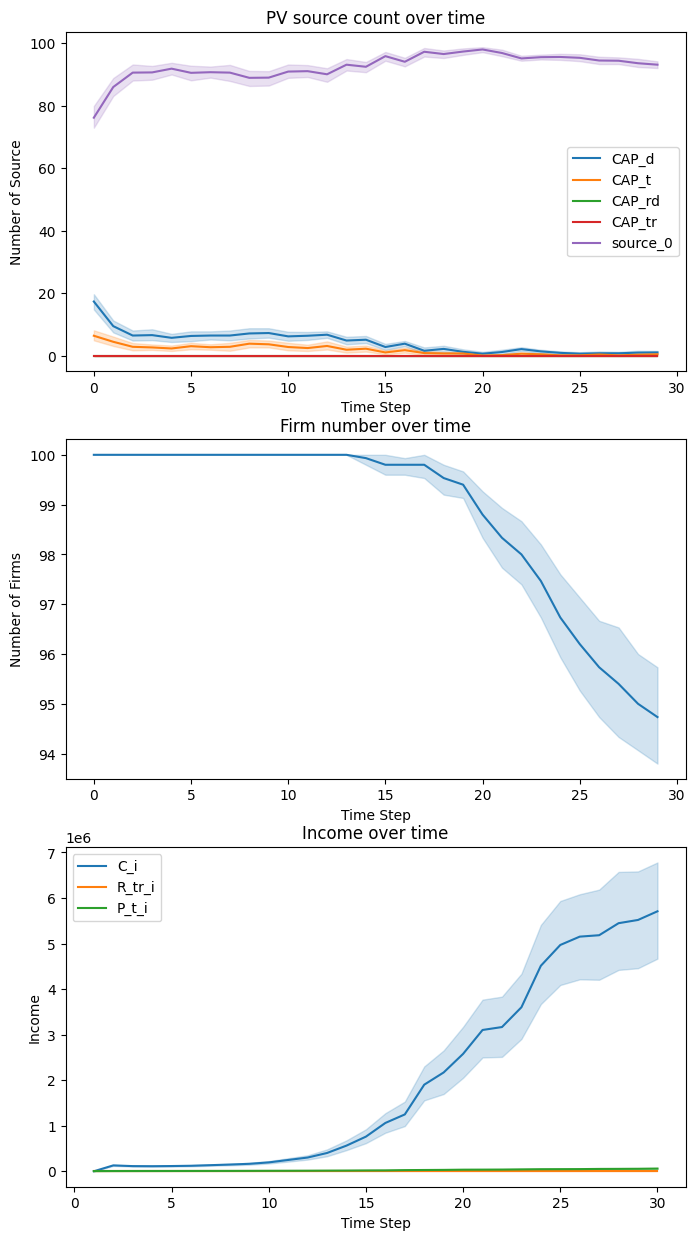

In [65]:
x, y = 3, 1
fig, axs = plt.subplots(x ,y, figsize=(8, 5 * x))
for var in ['CAP_d', 'CAP_t', 'CAP_rd', 'CAP_tr', 'source_0']:
    sns.lineplot(data=combined_model_data, x=combined_model_data.index, y=var,
                 ax=axs[0], label=var)
axs[0].set_title('PV source count over time')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Number of Source')
axs[0].legend()

sns.lineplot(data=combined_model_data, x=combined_model_data.index, y=combined_model_data['Firm_numbers'], ax=axs[1])
axs[1].set_title('Firm number over time')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Number of Firms')

income = ['C_i', 'R_tr_i', 'P_t_i']
for var in income:
    sns.lineplot(data=combined_agent_data, x='Step', y=var, ax=axs[2], label=var)

axs[2].set_title('Income over time')
axs[2].set_xlabel('Time Step')
axs[2].set_ylabel('Income')

#sns.lineplot(data=combined_agent_data, x='Step', y=combined_agent_data["Prod_line"], ax=axs[2])

plt.show()

### Other plots

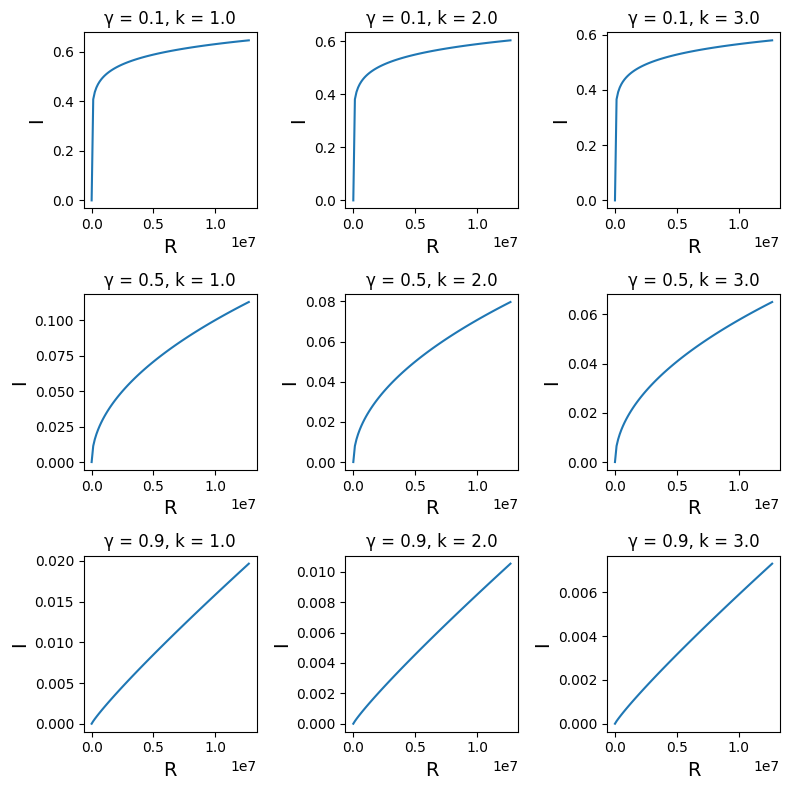

In [170]:
import numpy as np
import matplotlib.pyplot as plt

# 定义变量范围
R = np.linspace(0, 0.3*42350000, 100)  # R的范围
gamma_values = np.linspace(0.1, 0.9, 3)  # 不同的gamma值
k_values = np.linspace(1, 3, 3)  # 不同的k值

fig, axs = plt.subplots(3, 3, figsize=(8, 8))

# 生成图阵
for i, gamma in enumerate(gamma_values):
    for j, k in enumerate(k_values):
        I = ((R/1000000000) ** gamma) * (k ** (1 - gamma)) / k  # 计算I的值
        axs[i, j].plot(R, I)
        axs[i, j].set_title(f'γ = {gamma:.1f}, k = {k:.1f}')
        axs[i, j].set_xlabel('R', fontsize=14)
        axs[i, j].set_ylabel('I', fontsize=14)

plt.tight_layout()
#plt.savefig('IRk.png', ppi=150)
plt.show()
